# Introduction

## Background

<p>
A restaurant's chef in a Paris hotel, Hubert, has decided to quit his job to be more available for his wife and his young 2-year old daughter. The cost of living is quite high in Paris, Hubert knows that he has to keep a source of income.
<br>
Catering and hotel industry is quite a stressful environment; Hubert knows it and this is why he used to attend yoga classes. Being aware of how much yoga helped him the past few years, he has decided to become a yoga instructor. He wants his customer base to be the people working in catering and hotel industry. Hubert does not want his future customer to have to cross half of the city to get to his studio; consequently, he must settle his studio close to hotels and restaurants. 
</p>
<p>
As Paris is one of the most densely populated city in the world with more than 2 million people living in an area of 105.4 square kilometer, public transportation is often overcrowded and Hubert does not want to use public transportation daily. Consequently, Hubert has decided to buy an apartment and to settle his yoga studio inside his apartment.<br>
</p>
<p>
If possible, he would also like to be next to a park so that he can easily take a walk with his daughter or do outside yoga lessons.
</p>

## Problem

<p>
Hubert knows what venues he wants nearby his neighborhood. However, even he live in Paris for some years now, he does not really know what neighborhood he should choose between the 80 neighborhoods of the French capital. As Paris is one of the most expensive city for property prices, he knows that he must also consider the buying price of his future apartment.
</p>
<p>
We can help Hubert making up his decision. We know that the perfect neighborhoods will have many hotels and restaurants nearby, as well as a park. Moreover, a bonus would be to find him a neighborhood where there are not too many potential competitors, such as other yoga studios or gym/fitness centers, and where he can buy some sporting goods. Eventually, we have to keep in mind that Hubert will live in the apartment he will use as his yoga studio, so there must be some food shops around.
</p>

# Data requirement

## Property prices

The buying price is important for our new yoga teacher.<br>
I retrieved the property prices of Paris' neighborhoods in an article of the French newspaper LeParisien: http://www.leparisien.fr/paris-75/prix-de-l-immobilier-a-paris-par-quartiers-les-halles-s-emballent-le-xiiie-encore-abordable-23-05-2019-8077836.php. It gathers the property prices (in EUR/m²) of 78 out of the 80 neighborhoods of Paris. The neighborhoods with unknown property prices will not be considered.

## Venues

<p>
As our man wants to settle his yoga room close to restaurants and hotels, but without to many competitors nearby, we need to analyze the venues of each neighborhood.<br>
I used the Foursquare API to retrieve the venues nearby each neighborhoods. As a request can only return up to 100 venues, I decided to create one request per venues’ family listed below:
<ul>
<li>Food</li>
<li>Hotel</li>
<li>Outdoors</li>
<li>Gym / Fitness Center</li>
<li>Food & Drink Shop</li>
<li>Sporting Goods Shop</li>
</ul>   
</p>
<p>
As a result, I was able to retrieve much more than 100 venues for each neighborhood. For each request, I chose a radius of 500 meters around the neighborhood's latitude and longitude. This value seems reasonable, as the average equivalent radius  of Paris’ neighborhoods is 583 meters.
The equivalent radius is calculated as the root mean square of the surface dividded by $\pi$.
</p>

# Data collection

## Packages and data files

###### Import useful packages

In [1]:
try:
    import folium
    print('folium available and imported')
except:    
    !conda install -c conda-forge folium --yes
    import folium
    print ('folium imported')
    
try:
    from geopy.geocoders import Nominatim
    print('Nominatim from geopy.geocoders available and imported')
except:
    !conda install -c conda-forge geopy --yes 
    from geopy.geocoders import Nominatim
    print('Nominatim from geopy.geocoders imported')
    
import json
import pandas as pd
import numpy as np
import requests

folium available and imported
Nominatim from geopy.geocoders available and imported


###### Get coordinates from Paris

In [2]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris")
location = geolocator.geocode(address)
paris_latitude = location.latitude
paris_longitude = location.longitude

The geograpical coordinate of Paris are {{paris_latitude}}, {{paris_longitude}}

###### Get coordinates from Paris' neighborhoods

In [3]:
# The file is locally imported
neigh_json = r'quartier_paris.geojson'

df_neigh_json = pd.read_json(neigh_json)
df_neigh = pd.DataFrame(columns=['Neighborhood', 'Arrondissement', 'Latitude', 'Longitude', 'Surface'])
for i in np.arange(df_neigh_json.shape[0]):
    name=df_neigh_json.features[i]['properties']['name']
    arrt=df_neigh_json.features[i]['properties']['arrt']
    lat=df_neigh_json.features[i]['properties']['coordinates'][0]
    lon=df_neigh_json.features[i]['properties']['coordinates'][1]
    lon=df_neigh_json.features[i]['properties']['coordinates'][1]
    surface='%.0f'%df_neigh_json.features[i]['properties']['surface']
    df_neigh.loc[i,:]=[name, arrt, lat, lon, surface]

print('Shape: ', df_neigh.shape)
df_neigh.head()

Shape:  (80, 5)


Neighborhood Arrondissement Latitude Longitude  Surface
0                   Bercy             12  48.8352   2.38621  1902932
1  St-Germain-l'Auxerrois              1  48.8607   2.33491   869001
2                  Combat             19  48.8786   2.38013  1294988
3                  Ternes             17  48.8812   2.28996  1465071
4          Enfants-Rouges              3  48.8639   2.36312   271750

In [4]:
# Transform data type
df_neigh.Latitude = df_neigh.Latitude.astype('float64')
df_neigh.Longitude = df_neigh.Longitude.astype('float64')
df_neigh.Surface = df_neigh.Surface.astype('float64')
df_neigh.Arrondissement = df_neigh.Arrondissement.astype('int32')
df_neigh.dtypes

Neighborhood       object
Arrondissement      int32
Latitude          float64
Longitude         float64
Surface           float64
dtype: object

###### Get prices of Paris' neighborhoods

In [5]:
# The file is locally imported
df_paris_price = pd.read_csv('quartier_paris_prix.csv', sep=";")
df_paris_price.head()

Neighborhood  Price (EUR/m2)
0            Charonne            8317
1  Porte-Saint-Martin           10081
2   Porte-Saint-Denis            9917
3        Rochechouart           10377
4          Belleville            8485

In [6]:
if len(list(set(df_neigh.Neighborhood.unique())-set(df_paris_price.Neighborhood.unique())))!=0:
    print('The following neighborhoods are not in the DataFrame that contains prices:', 
      list(set(df_neigh.Neighborhood.unique())-set(df_paris_price.Neighborhood.unique())))

The following neighborhoods are not in the DataFrame that contains prices: ['Gaillon', "St-Germain-l'Auxerrois"]


Price is missing for 2 neighborhoods.<br>
We will drop these neighborhoods.

In [7]:
df_neigh.drop(df_neigh[df_neigh.Neighborhood=='Gaillon'].index, axis=0, inplace=True)
df_neigh.drop(df_neigh[df_neigh.Neighborhood=="St-Germain-l'Auxerrois"].index, axis=0, inplace=True)
print('Shape after dropping the two neighborhoods: {}'.format(df_neigh.shape))

Shape after dropping the two neighborhoods: (78, 5)


## Venues

In [8]:
# @hidden_cell
CLIENT_ID = "AHZ2C5FGS1QVEDO2S11XMGRVWI0SPVQRJBISKVVV2XLJPXTQ"
CLIENT_SECRET = "BXJEXQK4D4EPQBNSJDFB13FX3IU5PGBGVHF5H5KCSMZ1SFU2"
VERSION = '20190101' # Foursquare API version

### Prepare venues' collection

###### Define a function that will return venues

In [9]:
def getNearbyVenues(names, arrondissement, latitudes, longitudes, category, radius=500, LIMIT=200):
    
    venues_list=[]
    for name, arrt, lat, lng in zip(names, arrondissement, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&llAcc={}&radius={}&categoryId={}&limit={}&sortbyDistance={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            10,
            radius,
            category,
            LIMIT,
            1)
        
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print(url)            
            results=[]
        if results==[]:
            print('No venues for %s' %name)
            venues_list.append([(name, 
                                 arrt,
                                 lat, 
                                 lng, 
                                 None, 
                                 None, 
                                 None,  
                                 None)])
        
        # return only relevant information for each nearby venue
        else:
            venues_list.append([(name, 
                                 arrt,
                                 lat, 
                                 lng, 
                                 v['venue']['name'], 
                                 v['venue']['location']['lat'], 
                                 v['venue']['location']['lng'],  
                                 v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Arrondissement',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues, results)

###### Define our Foursquare's categories of interest

In [10]:
Cat={}
Cat["Food"]= "4d4b7105d754a06374d81259"
Cat["Hotel"]= "4bf58dd8d48988d1fa931735"
Cat["Outdoors"]= "4d4b7105d754a06377d81259"
Cat["Gym / Fitness Center"]= "4bf58dd8d48988d175941735"
Cat["Food & Drink Shop"]= "4bf58dd8d48988d1f9941735"
Cat["Sporting Goods Shop"]= "4bf58dd8d48988d1f2941735"

###### Initialize the DataFrame that will contain the number of venues of all the categories

In [11]:
df_paris = df_paris_price.merge(df_neigh, on="Neighborhood")
df_paris.drop('Surface', axis=1, inplace=True)
print('Shape: ',df_paris.shape)
df_paris.head()

Shape:  (78, 5)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude
0            Charonne            8317              20  48.854760   2.407430
1  Porte-Saint-Martin           10081              10  48.871245   2.361504
2   Porte-Saint-Denis            9917              10  48.873618   2.352283
3        Rochechouart           10377               9  48.879812   2.344861
4          Belleville            8485              20  48.871531   2.387549

In [12]:
df_paris=df_paris.sort_values(by='Neighborhood')
df_paris.reset_index(drop=True, inplace=True)
df_paris.head()

Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude
0         Amerique            7844              19  48.881638   2.395440
1         Archives           13017               3  48.859192   2.363205
2          Arsenal           12781               4  48.851585   2.364768
3  Arts-et-Metiers           11255               3  48.866470   2.357083
4          Auteuil            9747              16  48.849118   2.265405

### Request data from Foursquare

##### "Food"

###### Get venues

In [13]:
paris_venues_food, venues_results = getNearbyVenues(names= df_neigh.Neighborhood,
                                                    arrondissement= df_neigh.Arrondissement,
                                                    latitudes= df_neigh.Latitude,
                                                    longitudes= df_neigh.Longitude,
                                                    radius=500,
                                                    LIMIT=100,
                                                    category=Cat["Food"])

###### Check categories

In [14]:
print('Shape :', paris_venues_food.shape)
paris_venues_food['Venue Category'].sort_values().unique()

Shape : (4782, 8)


array(['Afghan Restaurant', 'African Restaurant', 'Alsatian Restaurant',
       'American Restaurant', 'Arepa Restaurant',
       'Argentinian Restaurant', 'Asian Restaurant',
       'Auvergne Restaurant', 'BBQ Joint', 'Bagel Shop', 'Bakery',
       'Basque Restaurant', 'Belgian Restaurant', 'Bistro', 'Brasserie',
       'Brazilian Restaurant', 'Breakfast Spot', 'Breton Restaurant',
       'Buffet', 'Burger Joint', 'Burgundian Restaurant', 'Burrito Place',
       'Cafeteria', 'Café', 'Cajun / Creole Restaurant',
       'Cambodian Restaurant', 'Cantonese Restaurant',
       'Caribbean Restaurant', 'Caucasian Restaurant', "Ch'ti Restaurant",
       'Chinese Restaurant', 'Colombian Restaurant',
       'Comfort Food Restaurant', 'Corsican Restaurant', 'Creperie',
       'Cuban Restaurant', 'Deli / Bodega', 'Dim Sum Restaurant', 'Diner',
       'Doner Restaurant', 'Donut Shop', 'Eastern European Restaurant',
       'Empanada Restaurant', 'English Restaurant',
       'Ethiopian Restaurant', 

In [15]:
paris_venues_food.dropna(inplace=True)
print('Shape :', paris_venues_food.shape)

Shape : (4782, 8)


###### Fill DataFrame

In [16]:
df_paris= df_paris.merge(
    pd.DataFrame(paris_venues_food.groupby('Neighborhood').Venue.count()),
    on='Neighborhood', how='outer')
df_paris.rename(columns={'Venue': 'Food'}, inplace=True)
print(df_paris.shape)
df_paris.head()

(78, 6)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  Food
0         Amerique            7844              19  48.881638   2.395440    10
1         Archives           13017               3  48.859192   2.363205   100
2          Arsenal           12781               4  48.851585   2.364768    64
3  Arts-et-Metiers           11255               3  48.866470   2.357083   100
4          Auteuil            9747              16  48.849118   2.265405    39

##### "Hotel"

###### Get venues

In [17]:
paris_venues_hotel, venues_results = getNearbyVenues(names= df_neigh.Neighborhood,
                                                     arrondissement= df_neigh.Arrondissement,
                                                     latitudes= df_neigh.Latitude,
                                                     longitudes= df_neigh.Longitude,
                                                     radius=500,
                                                     LIMIT=100,
                                                     category=Cat["Hotel"])

No venues for Saint-Fargeau
No venues for Chapelle


###### Check categories

In [18]:
print('Shape: ', paris_venues_hotel.shape)
print(paris_venues_hotel['Venue Category'].unique())

Shape:  (2335, 8)
['Hotel' 'Hostel' 'Bed & Breakfast' 'Resort' 'Hotel Bar' 'Travel Agency'
 'Vacation Rental' 'Residential Building (Apartment / Condo)' 'Café'
 'French Restaurant' 'General Travel' 'Motel' 'Italian Restaurant'
 'Restaurant' 'Assisted Living' 'Bar' 'Bistro' 'Sandwich Place'
 'Hotel Pool' 'Roof Deck' 'Tapas Restaurant' 'Boarding House' None]


In [19]:
hotel_list = ["Bed & Breakfast", "Boarding House", "Hotel", "Hostel", "Hotel Pool",
              "Hotel Bar", "Inn", "Motel", "Resort", "Vacation Rental"]
boolean_list = [item in hotel_list for item in paris_venues_hotel['Venue Category']]
paris_venues_hotel = paris_venues_hotel[boolean_list]
paris_venues_hotel.reset_index(drop=True)
paris_venues_hotel.dropna(inplace=True)
print('Shape: ', paris_venues_hotel.shape)

Shape:  (2226, 8)


###### Fill DataFrame

In [20]:
df_paris= df_paris.merge(
    pd.DataFrame(paris_venues_hotel.groupby('Neighborhood').Venue.count()),
    on='Neighborhood', how='outer')
df_paris.rename(columns={'Venue': 'Hotel'}, inplace=True)
print(df_paris.shape)
df_paris.head()

(78, 7)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  
0    10    1.0  
1   100   31.0  
2    64   31.0  
3   100   46.0  
4    39    3.0

In [21]:
df_paris.Hotel.fillna(value=0, inplace=True)
df_paris.Hotel = df_paris.Hotel.astype('int64')
print(df_paris.shape)
df_paris.head()

(78, 7)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  
0    10      1  
1   100     31  
2    64     31  
3   100     46  
4    39      3

##### "Outdoors"

###### Get venues

In [22]:
paris_venues_outdoors, venues_results = getNearbyVenues(names= df_neigh.Neighborhood,
                                                        arrondissement= df_neigh.Arrondissement,
                                                        latitudes= df_neigh.Latitude,     
                                                        longitudes= df_neigh.Longitude,
                                                        radius=500,
                                                        LIMIT=100,
                                                        category=Cat["Outdoors"])

###### Check catagories

In [23]:
print('Shape: ', paris_venues_outdoors.shape)
paris_venues_outdoors['Venue Category'].sort_values().unique()

Shape:  (1198, 8)


array(['Athletics & Sports', 'Baseball Field', 'Basketball Court',
       'Botanical Garden', 'Boxing Gym', 'Canal', 'Canal Lock', 'Cave',
       'Climbing Gym', 'Cycle Studio', 'Dive Spot', 'Fountain', 'Garden',
       'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym',
       'Harbor / Marina', 'Lake', 'Martial Arts Dojo', 'Nature Preserve',
       'Outdoors & Recreation', 'Palace', 'Park', 'Pedestrian Plaza',
       'Pilates Studio', 'Playground', 'Plaza', 'Pool',
       'Recreation Center', 'River', 'Roof Deck', 'Scenic Lookout',
       'Sculpture Garden', 'Skate Park', 'Skating Rink', 'Soccer Field',
       'Sports Club', 'Squash Court', 'Tennis Court', 'Track', 'Trail',
       'Vineyard', 'Waterfall', 'Waterfront', 'Yoga Studio'], dtype=object)

In [24]:
outdoors_list = ["Botanical Garden", "Forest", "Garden", "Harbor / Marina",
                 "Hill", "Lake", "Nature Preserve", "Park", "Playground", "Trail", "Waterfront"]
boolean_list = [item in outdoors_list for item in paris_venues_outdoors['Venue Category']]
paris_venues_outdoors = paris_venues_outdoors[boolean_list]
paris_venues_outdoors.reset_index(drop=True)
paris_venues_outdoors.dropna(inplace=True)
print('Shape: ', paris_venues_outdoors.shape)

Shape:  (320, 8)


###### Fill DataFrame

In [26]:
df_paris= df_paris.merge(
    pd.DataFrame(paris_venues_outdoors.groupby('Neighborhood').Venue.count()),
    on='Neighborhood', how='outer')
df_paris.rename(columns={'Venue': 'Outdoors'}, inplace=True)
print(df_paris.shape)
df_paris.head()

(78, 8)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  
0    10      1       1.0  
1   100     31      14.0  
2    64     31      12.0  
3   100     46       2.0  
4    39      3       NaN

In [27]:
df_paris.Outdoors.fillna(value=0, inplace=True)
df_paris.Outdoors = df_paris.Outdoors.astype('int64')
print(df_paris.shape)
df_paris.head()

(78, 8)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  
0    10      1         1  
1   100     31        14  
2    64     31        12  
3   100     46         2  
4    39      3         0

##### "Gym / Fitness Center"

###### Get venues

In [28]:
paris_venues_gym, venues_results = getNearbyVenues(names= df_neigh.Neighborhood,
                                                   arrondissement= df_neigh.Arrondissement,
                                                   latitudes= df_neigh.Latitude,
                                                   longitudes= df_neigh.Longitude,
                                                   radius=500,
                                                   LIMIT=100,
                                                   category=Cat["Gym / Fitness Center"])

###### Check categories

In [29]:
print('Shape: ', paris_venues_gym.shape)
paris_venues_gym['Venue Category'].sort_values().unique()

Shape:  (413, 8)


array(['Alternative Healer', 'Athletics & Sports', 'Boxing Gym',
       'Business Service', 'Climbing Gym', 'Coworking Space',
       'Cycle Studio', 'Dance Studio', 'Gym', 'Gym / Fitness Center',
       'Gym Pool', 'Gymnastics Gym', 'Health & Beauty Service',
       'Laboratory', 'Martial Arts Dojo', 'Massage Studio',
       'Medical Center', 'Pilates Studio', 'Pool', 'Spa', 'Track',
       'Track Stadium', 'University', 'Yoga Studio'], dtype=object)

In [30]:
gym_list = ["Boxing Gym", "Climbing Gym", "Cycle Studio", "Gym", "Gym / Fitness Center", "Gym Pool",
            "Gymnastics Gym", "Martial Arts Dojo", "Pilates Studio", "Track", "Yoga Studio"]
boolean_list = [item in gym_list for item in paris_venues_gym['Venue Category']]
paris_venues_gym = paris_venues_gym[boolean_list]
paris_venues_gym.reset_index(drop=True)
paris_venues_gym.dropna(inplace=True)
print('Shape: ', paris_venues_gym.shape)

Shape:  (392, 8)


###### Fill DataFrame

In [31]:
df_paris= df_paris.merge(
    pd.DataFrame(paris_venues_gym.groupby('Neighborhood').Venue.count()),
    on='Neighborhood', how='outer')
df_paris.rename(columns={'Venue': 'Gym / Fitness Center'}, inplace=True)
print(df_paris.shape)
df_paris.head()

(78, 9)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  
0    10      1         1                     3  
1   100     31        14                     2  
2    64     31        12                     4  
3   100     46         2                     8  
4    39      3         0                     5

##### "Food & Drink Shop"

###### Get venues

In [33]:
paris_venues_shop, venues_results = getNearbyVenues(names= df_neigh.Neighborhood,
                                                    arrondissement= df_neigh.Arrondissement,
                                                    latitudes= df_neigh.Latitude,
                                                    longitudes= df_neigh.Longitude,
                                                    radius=500,
                                                    LIMIT=100,
                                                    category=Cat["Food & Drink Shop"])

###### Check catagories

In [34]:
print('Shape: ', paris_venues_shop.shape)
paris_venues_shop['Venue Category'].sort_values().unique()

Shape:  (2075, 8)


array(['American Restaurant', 'Bakery', 'Bar', 'Beer Bar', 'Beer Store',
       'Bistro', 'Brasserie', 'Breakfast Spot', 'Butcher', 'Café',
       'Candy Store', 'Cheese Shop', 'Chocolate Shop', 'Coffee Shop',
       'Comfort Food Restaurant', 'Convenience Store', 'Deli / Bodega',
       'Dessert Shop', 'Discount Store', 'Entertainment Service',
       'Event Service', 'Farmers Market', 'Fast Food Restaurant',
       'Fish Market', 'Food & Drink Shop', 'Food Service',
       'French Restaurant', 'Furniture / Home Store', 'Gastropub',
       'Gourmet Shop', 'Greek Restaurant', 'Grocery Store',
       'Health Food Store', 'Italian Restaurant', 'Japanese Restaurant',
       'Jazz Club', 'Kebab Restaurant', 'Liquor Store', 'Lounge',
       'Market', 'Mediterranean Restaurant', 'Office', 'Optical Shop',
       'Organic Grocery', 'Pet Café', 'Photography Studio', 'Pub',
       'Restaurant', 'Sandwich Place', 'Seafood Restaurant',
       'Southwestern French Restaurant', 'Sports Bar', 'Steakh

In [35]:
shop_list = ["Beer Store", "Butcher", "Cheese Shop", "Dairy Store", "Farmers Market", "Fish Market",
             "Food Service", "Gourmet Shop", "Grocery Store", "Health Food Store", "Liquor Store",
             "Organic Grocery", "Sausage Shop", "Street Food Gathering", "Supermarket", "Wine Shop"]
boolean_list = [item in shop_list for item in paris_venues_shop['Venue Category']]
paris_venues_shop = paris_venues_shop[boolean_list]
paris_venues_shop.reset_index(drop=True)
paris_venues_shop.dropna(inplace=True)
print('Shape: ', paris_venues_shop.shape)

Shape:  (1680, 8)


###### Fill DataFrame

In [36]:
df_paris= df_paris.merge(
    pd.DataFrame(paris_venues_shop.groupby('Neighborhood').Venue.count()),
    on='Neighborhood', how='outer')
df_paris.rename(columns={'Venue': 'Food & Drink Shop'}, inplace=True)
print(df_paris.shape)
df_paris.head()

(78, 10)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  
0    10      1         1                     3                  7  
1   100     31        14                     2                 35  
2    64     31        12                     4                 16  
3   100     46         2                     8                 31  
4    39      3         0                     5                 15

##### "Sporting Goods Shop"

###### Get venues

In [38]:
paris_venues_sport, venues_results = getNearbyVenues(names= df_neigh.Neighborhood,
                                                     arrondissement= df_neigh.Arrondissement,
                                                     latitudes= df_neigh.Latitude,
                                                     longitudes= df_neigh.Longitude,
                                                     radius=500,
                                                     LIMIT=100,
                                                     category=Cat["Sporting Goods Shop"])

No venues for Combat
No venues for Jardin-des-Plantes
No venues for Epinettes
No venues for Ecole-Militaire
No venues for Maison-Blanche
No venues for Parc-de-Montsouris
No venues for Plaisance
No venues for Pont-de-Flandre
No venues for Javel
No venues for Petit-Montrouge
No venues for Porte-Dauphine
No venues for Quinze-Vingts
No venues for Saint-Fargeau
No venues for Montparnasse
No venues for Grandes-Carrieres
No venues for Chapelle
No venues for Villette
No venues for Amerique
No venues for Goutte-d'Or
No venues for Invalides
No venues for Gros-Caillou


###### Check categories

In [39]:
print('Shape: ', paris_venues_sport.shape)
paris_venues_sport['Venue Category'].sort_values().unique()

Shape:  (210, 8)


array(['Health & Beauty Service', "Men's Store", 'Outdoor Supply Store',
       'Sporting Goods Shop', None], dtype=object)

In [40]:
sport_list = ["Sporting Goods Shop"]
boolean_list = [item in sport_list for item in paris_venues_sport['Venue Category']]
paris_venues_sport = paris_venues_sport[boolean_list]
paris_venues_sport.reset_index(drop=True)
paris_venues_sport.dropna(inplace=True)
print('Shape: ', paris_venues_sport.shape)

Shape:  (181, 8)


###### Fill DataFrame

In [41]:
df_paris= df_paris.merge(
    pd.DataFrame(paris_venues_sport.groupby('Neighborhood').Venue.count()),
    on='Neighborhood', how='outer')
df_paris.rename(columns={'Venue': 'Sporting Goods Shop'}, inplace=True)
print(df_paris.shape)
df_paris.head()

(78, 11)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  
0                  NaN  
1                  8.0  
2                  6.0  
3                  1.0  
4                  1.0

In [42]:
df_paris['Sporting Goods Shop'].fillna(value=0, inplace=True)
df_paris['Sporting Goods Shop'] = df_paris['Sporting Goods Shop'].astype('int64')
print(df_paris.shape)
df_paris.head()

(78, 11)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  
0                    0  
1                    8  
2                    6  
3                    1  
4                    1

### Venues' DataFrames

###### Merge all the venues in a single DataFrame

In [43]:
paris_venues= pd.DataFrame(columns=paris_venues_food.columns)
paris_venues= paris_venues.append(paris_venues_food).reset_index(drop=True)
paris_venues= paris_venues.append(paris_venues_hotel).reset_index(drop=True)
paris_venues= paris_venues.append(paris_venues_outdoors).reset_index(drop=True)
paris_venues= paris_venues.append(paris_venues_gym).reset_index(drop=True)
paris_venues= paris_venues.append(paris_venues_shop).reset_index(drop=True)
paris_venues= paris_venues.append(paris_venues_sport).reset_index(drop=True)

print('Shape: ', paris_venues.shape)
paris_venues.head()

Shape:  (9581, 8)


Neighborhood Arrondissement  Neighborhood Latitude  Neighborhood Longitude  \
0        Bercy             12              48.835209                 2.38621   
1        Bercy             12              48.835209                 2.38621   
2        Bercy             12              48.835209                 2.38621   
3        Bercy             12              48.835209                 2.38621   
4        Bercy             12              48.835209                 2.38621   

                    Venue  Venue Latitude  Venue Longitude  \
0  L'Auberge Aveyronnaise       48.834772         2.386037   
1            Factory & Co       48.832878         2.386224   
2              Pedra Alta       48.836409         2.387307   
3          Cafe Cartouche       48.835937         2.385806   
4       Ernest & Valentin       48.837986         2.390373   

          Venue Category  
0      French Restaurant  
1             Bagel Shop  
2  Portuguese Restaurant  
3      French Restaurant  
4                 Bakery

In [44]:
# Remove empty rows
paris_venues.dropna(inplace=True)
print('Shape: ', paris_venues.shape)

Shape:  (9581, 8)


There is a total number of {{paris_venues.shape[0]}} venues

###### Create a DataFrame with one-hot encoded venues, grouped by neighborhoods

In [45]:
# create dummy columns
paris_dummy_venues = pd.get_dummies(paris_venues['Venue Category'])
paris_dummy_venues.reset_index(drop=True)

# set Neighborhood as the 1st columns
columns = [['Neighborhood']+list(paris_dummy_venues.columns)][0]
paris_dummy_venues['Neighborhood'] = paris_venues['Neighborhood']
paris_dummy_venues = paris_dummy_venues[columns]

paris_venues_grouped = paris_dummy_venues.groupby('Neighborhood').sum()
print('Shape: ', paris_venues_grouped.shape)
paris_venues_grouped.head()

Shape:  (78, 170)


Afghan Restaurant  African Restaurant  Alsatian Restaurant  \
Neighborhood                                                                  
Amerique                         0                   0                    0   
Archives                         0                   1                    0   
Arsenal                          0                   0                    0   
Arts-et-Metiers                  0                   0                    0   
Auteuil                          0                   0                    0   

                 American Restaurant  Arepa Restaurant  \
Neighborhood                                             
Amerique                           0                 0   
Archives                           0                 0   
Arsenal                            0                 0   
Arts-et-Metiers                    0                 0   
Auteuil                            0                 0   

                 Argentinian Restaurant  Asian Restaurant  \
Neighborhood                                                
Amerique                              0                 1   
Archives                              0                 2   
Arsenal                               0                 1   
Arts-et-Metiers                       1                 2   
Auteuil                               0                 3   

                 Auvergne Restaurant  BBQ Joint  Bagel Shop  ...  \
Neighborhood                                                 ...   
Amerique                           0          0           0  ...   
Archives                           0          0           0  ...   
Arsenal                            0          0           1  ...   
Arts-et-Metiers                    2          0           0  ...   
Auteuil                            0          0           0  ...   

                 Trattoria/Osteria  Turkish Restaurant  Udon Restaurant  \
Neighborhood                                                              
Amerique                         0                   0                0   
Archives                         0                   0                0   
Arsenal                          0                   0                0   
Arts-et-Metiers                  0                   0                0   
Auteuil                          0                   0                0   

                 Vacation Rental  Vegetarian / Vegan Restaurant  \
Neighborhood                                                      
Amerique                       0                              0   
Archives                       0                              1   
Arsenal                        0                              2   
Arts-et-Metiers                0                              3   
Auteuil                        0                              0   

                 Venezuelan Restaurant  Vietnamese Restaurant  Waterfront  \
Neighborhood                                                                
Amerique                             0                      1           0   
Archives                             0                      0           0   
Arsenal                              0                      0           0   
Arts-et-Metiers                      0                      5           0   
Auteuil                              0                      0           0   

                 Wine Shop  Yoga Studio  
Neighborhood                             
Amerique                 0            0  
Archives                11            2  
Arsenal                  4            1  
Arts-et-Metiers          7            2  
Auteuil                  3            0  

[5 rows x 170 columns]

###### Create a DataFrame with the most common venues of each neighborhood

In [46]:
paris_common_venues = pd.DataFrame(columns=['1st', '2nd', '3rd', '4th', '5th',
                                            '6th', '7th', '8th', '9th', '10th'],
                                   index=paris_venues_grouped.index)

for neigh in paris_venues_grouped.index:
    row = paris_venues_grouped.loc[neigh,:]  #read line
    row_most_values = row.sort_values(ascending=False)[:10] # sort values and keep 10 first
    venues = row_most_values.index
    neigh_list = [str(i)+' '+j for i,j in zip(row_most_values, venues)]
    paris_common_venues.loc[neigh,:] = neigh_list

print('Shape: ',paris_common_venues.shape)
paris_common_venues.head()

Shape:  (78, 10)


1st                   2nd  \
Neighborhood                                                 
Amerique               6 Supermarket                3 Café   
Archives                    30 Hotel  22 French Restaurant   
Arsenal                     30 Hotel  18 French Restaurant   
Arts-et-Metiers             46 Hotel  19 French Restaurant   
Auteuil          9 French Restaurant         8 Supermarket   

                                  3rd                    4th  \
Neighborhood                                                   
Amerique                     2 Bistro    2 French Restaurant   
Archives                 11 Wine Shop  8 Sporting Goods Shop   
Arsenal          7 Italian Restaurant  6 Sporting Goods Shop   
Arts-et-Metiers        11 Supermarket            7 Wine Shop   
Auteuil                      7 Bakery          4 Pizza Place   

                                    5th                    6th  \
Neighborhood                                                     
Amerique         1 Gym / Fitness Center        1 Grocery Store   
Archives                   8 Restaurant                 7 Park   
Arsenal                          6 Park            4 Gastropub   
Arts-et-Metiers            6 Restaurant  5 Japanese Restaurant   
Auteuil           4 Japanese Restaurant                3 Hotel   

                                     7th                     8th  \
Neighborhood                                                       
Amerique                        1 Bakery                   1 Gym   
Archives                        7 Garden                  7 Café   
Arsenal                      4 Wine Shop           3 Pizza Place   
Arts-et-Metiers  5 Vietnamese Restaurant    5 Chinese Restaurant   
Auteuil                      3 Wine Shop  3 Gym / Fitness Center   

                                9th                  10th  
Neighborhood                                               
Amerique          1 Bed & Breakfast    1 Asian Restaurant  
Archives             6 Gourmet Shop  6 Italian Restaurant  
Arsenal                    3 Bakery  3 Seafood Restaurant  
Arts-et-Metiers   5 Organic Grocery                5 Café  
Auteuil          3 Asian Restaurant  3 Italian Restaurant

# Explore data

## Venues

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

###### Define a "Good venues" column in Paris DataFrame as the total of the valuable venue categories

In [48]:
# Positive total number of venues: all categories except Gym / Fitness Center
df_paris['Good Venues'] = df_paris['Food']+\
df_paris['Hotel']+\
df_paris['Outdoors']+\
df_paris['Food & Drink Shop']+\
df_paris['Sporting Goods Shop']
print(df_paris.shape)
df_paris.head()

(78, 12)


Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  Good Venues  
0                    0           19  
1                    8          188  
2                    6          129  
3                    1          180  
4                    1           58

###### Display number of "good" venues on a map

In [91]:
# + / - 0.1 to prevent error
scale = list(i for i in np.linspace(start=df_paris['Good Venues'].min()-.1,
                                    stop=df_paris['Good Venues'].max()+.1,
                                    num=6))
scale

[18.9, 61.94, 104.97999999999999, 148.02, 191.06, 234.1]

In [92]:
paris_good_venues_map = folium.Map(location=[paris_latitude, paris_longitude], 
                       zoom_start=12, tiles='cartodbpositron')
paris_good_venues_map.choropleth(
    geo_data=neigh_json,
    data= df_paris,
    columns=['Neighborhood', 'Good Venues'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name= 'Number of "good" venues',
    threshold_scale=scale
)

for arrt, neigh, lat, lng, venue in zip(df_paris.Arrondissement,
                                        df_paris.Neighborhood,
                                        df_paris.Latitude, 
                                        df_paris.Longitude,
                                        df_paris['Good Venues']):
    label = '%s, %se arrt: \n %d valuable venues'%(neigh, arrt, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_good_venues_map)  
    
paris_good_venues_map.save("Paris_good_venues_map.html")

paris_good_venues_map

###### Display number of "good" venues on a bar chart

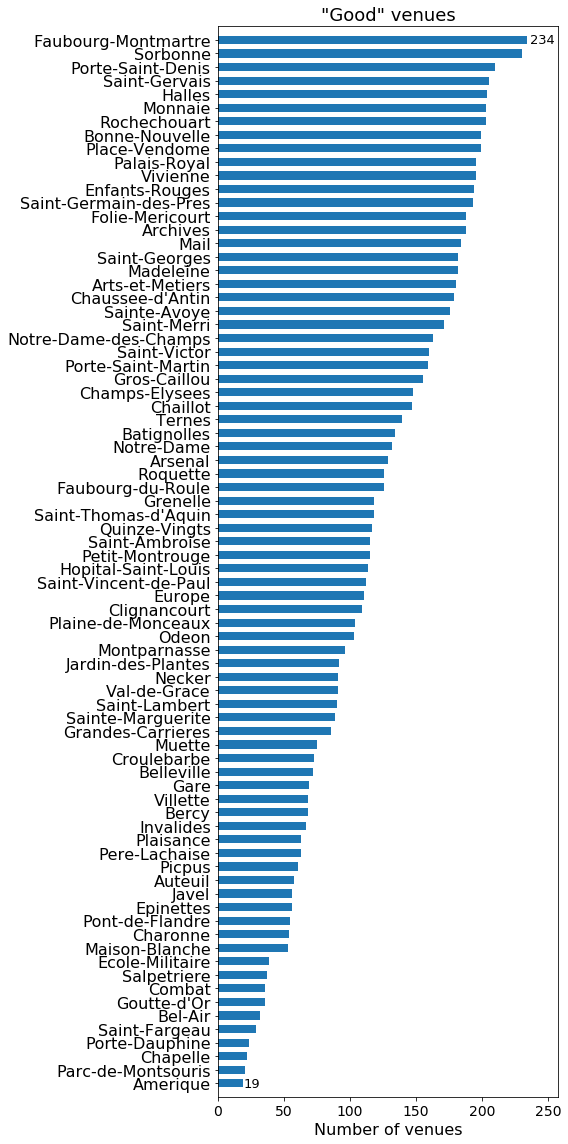

In [51]:
fig=plt.figure(figsize=(8,16))

labels = df_paris.sort_values(by='Good Venues', ascending=True).Neighborhood
X = np.arange(len(labels))

W = df_paris['Good Venues'].sort_values(ascending=True)

H=.6

rects = plt.barh(y=X, width=W, height=H)

plt.ylim(-1,len(X))
plt.xlim(0,1.1*df_paris['Good Venues'].max())
plt.yticks(ticks=X, labels=labels, fontsize=16)
plt.xticks(fontsize=14)
plt.title('"Good" venues', fontsize=18)
plt.xlabel('Number of venues', fontsize=16)

# Add text for 1st and last neighborhoods
plt.text(rects[0].get_width()*1.01, 
         rects[0].get_y()+rects[0].get_height()/2.0,
         '%d' %rects[0].get_width(),
         va='center', ha='left', fontsize=13)

plt.text(rects[-1].get_width()*1.01, 
         rects[-1].get_y()+rects[-1].get_height()/2.0,
         '%d' %rects[-1].get_width(),
         va='center', ha='left', fontsize=13)

plt.tight_layout()    
plt.savefig('Number of good venues per neighborhood.png')

###### Display the number of Gym / Fitness Center on a map

In [54]:
# + 0.1 to prevent error
scale = list(i for i in np.linspace(start=df_paris['Gym / Fitness Center'].min()+.1,
                                    stop=df_paris['Gym / Fitness Center'].max()+.1,
                                    num=5))
scale

[1.1, 4.8500000000000005, 8.600000000000001, 12.350000000000001, 16.1]

In [55]:
paris_gym_map = folium.Map(location=[paris_latitude, paris_longitude], 
                       zoom_start=12, tiles='cartodbpositron')
paris_gym_map.choropleth(
    geo_data=neigh_json,
    data= df_paris,
    columns=['Neighborhood', 'Gym / Fitness Center'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name= 'Number of "Gym / Fitness Center" venues',
    threshold_scale=scale
)

for arrt, neigh, lat, lng, venue in zip(df_paris.Arrondissement,
                                        df_paris.Neighborhood,
                                        df_paris.Latitude, 
                                        df_paris.Longitude,
                                        df_paris['Gym / Fitness Center']):
    label = '%s, %se arrt: \n %d gym/fitness centers'%(neigh, arrt, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_gym_map)  
    
paris_gym_map.save("Paris_gym_map.html")

paris_gym_map

###### Display number of "Gym / Fitness Center" venues on a bar chart

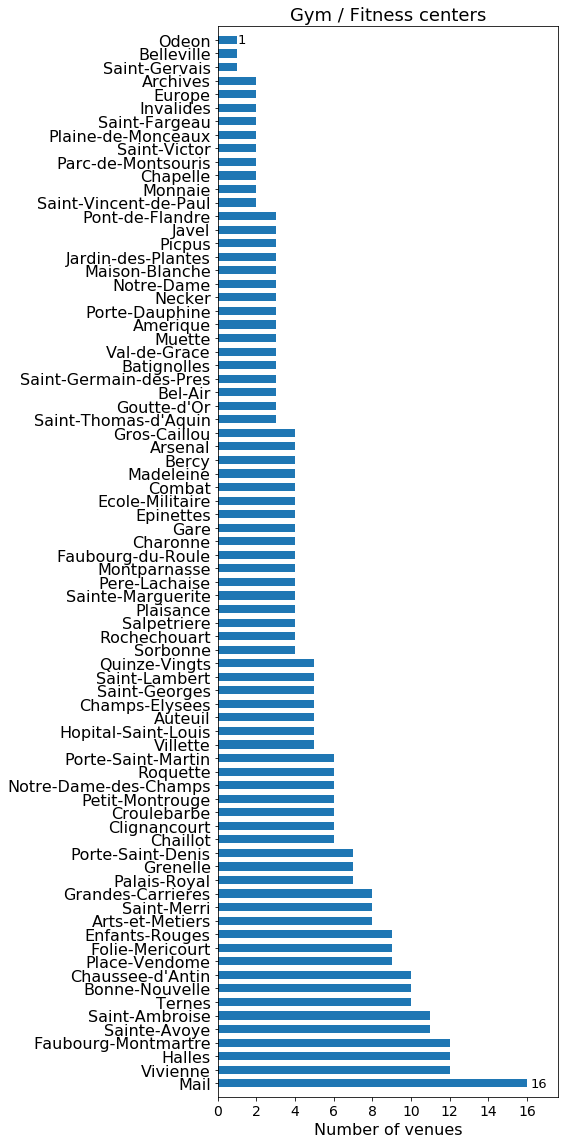

In [56]:
fig=plt.figure(figsize=(8,16))

labels = df_paris.sort_values(by='Gym / Fitness Center', ascending=False).Neighborhood
X = np.arange(len(labels))

W = df_paris['Gym / Fitness Center'].sort_values(ascending=False)

H=.6

rects = plt.barh(y=X, width=W, height=H)

plt.ylim(-1,len(X))
plt.xlim(0,1.1*df_paris['Gym / Fitness Center'].max())
plt.yticks(ticks=X, labels=labels, fontsize=16)
plt.xticks(fontsize=14)
plt.title('Gym / Fitness centers', fontsize=18)
plt.xlabel('Number of venues', fontsize=16)

# Add text for 1st and last neighborhoods
plt.text(rects[0].get_width()*1.01, 
         rects[0].get_y()+rects[0].get_height()/2.0,
         '%d' %rects[0].get_width(),
         va='center', ha='left', fontsize=13)

plt.text(rects[-1].get_width()*1.01, 
         rects[-1].get_y()+rects[-1].get_height()/2.0,
         '%d' %rects[-1].get_width(),
         va='center', ha='left', fontsize=13)

plt.tight_layout()    
plt.savefig('Number of Gym Fitness Centers per neighborhood.png')

## Property prices

###### Display prices and coordinates on a map

In [57]:
# + / - .1 to prevent error
scale = list(i for i in np.linspace(start=df_paris['Price (EUR/m2)'].min()-.1,
                                    stop=df_paris['Price (EUR/m2)'].max()+.1,
                                    num=6))
scale

[7286.9, 8953.74, 10620.58, 12287.42, 13954.26, 15621.1]

In [58]:
paris_prices_map = folium.Map(location=[paris_latitude, paris_longitude], 
                       zoom_start=12,
                       tiles='cartodbpositron')
paris_prices_map.choropleth(
    geo_data=neigh_json,
    data= df_paris_price,
    columns=['Neighborhood', 'Price (EUR/m2)'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name= '€ per m2',
    threshold_scale=scale
)

for arrt, neigh, lat, lng, price in zip(df_neigh.Arrondissement,
                                        df_neigh.Neighborhood,
                                        df_neigh.Latitude, 
                                        df_neigh.Longitude,
                                        df_paris['Price (EUR/m2)']):
    label = '{}, {}e arrt: {} EUR/m2'.format(neigh, arrt, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_prices_map)  

paris_prices_map.save("Paris_prices_map.html")
paris_prices_map

###### Display property prices on a bar chart

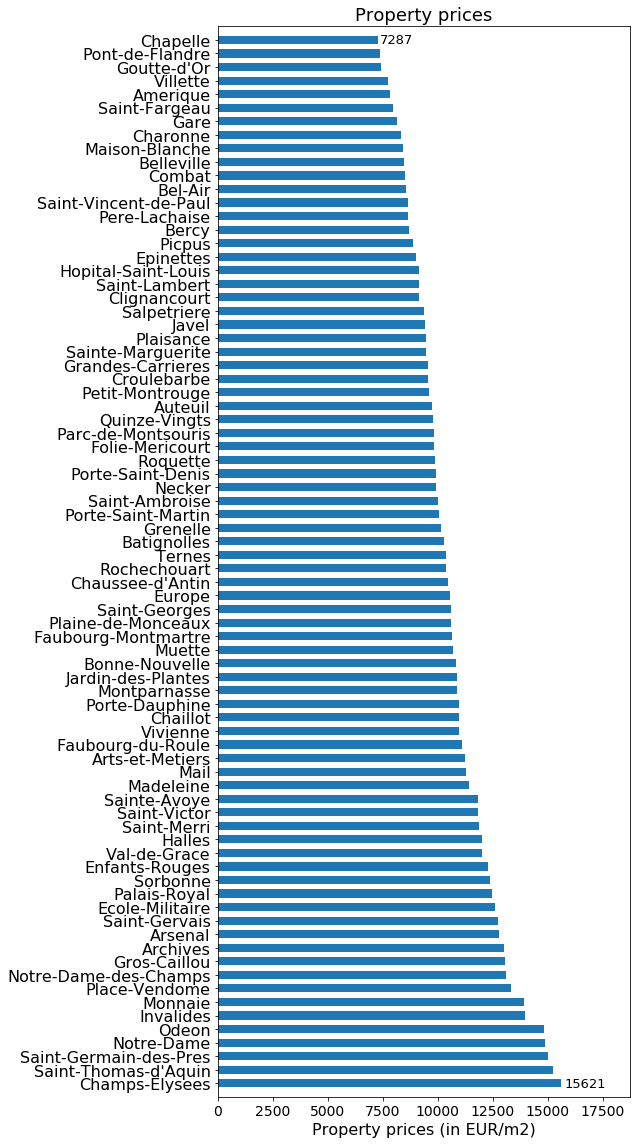

In [59]:
fig=plt.figure(figsize=(9,16))

labels = df_paris.sort_values(by='Price (EUR/m2)', ascending=False).Neighborhood
X = np.arange(len(labels))

W = df_paris['Price (EUR/m2)'].sort_values(ascending=False)

H=.6

rects = plt.barh(y=X, width=W, height=H)

plt.ylim(-1,len(X))
plt.xlim(0,1.2*df_paris['Price (EUR/m2)'].max())
plt.yticks(ticks=X, labels=labels, fontsize=16)
plt.xticks(fontsize=14)
plt.title('Property prices', fontsize=18)
plt.xlabel('Property prices (in EUR/m2)', fontsize=16)

# Add text for 1st and last neighborhoods
plt.text(rects[0].get_width()*1.01, 
         rects[0].get_y()+rects[0].get_height()/2.0,
         '%d' %rects[0].get_width(),
         va='center', ha='left', fontsize=13)

plt.text(rects[-1].get_width()*1.01, 
         rects[-1].get_y()+rects[-1].get_height()/2.0,
         '%d' %rects[-1].get_width(),
         va='center', ha='left', fontsize=13)

plt.tight_layout()    
plt.savefig('Property pricees per neighborhood.png')

###### Display map colored venues, circle size price

In [60]:
# + / - 0.1 to prevent error
scale = list(i for i in np.linspace(start=df_paris['Good Venues'].min()-.1,
                                    stop=df_paris['Good Venues'].max()+.1,
                                    num=6))
scale

[18.9, 61.94, 104.97999999999999, 148.02, 191.06, 234.1]

In [61]:
paris_value_map = folium.Map(location=[paris_latitude, paris_longitude], 
                       zoom_start=12, tiles='cartodbpositron')
paris_value_map.choropleth(
    geo_data=neigh_json,
    data= df_paris,
    columns=['Neighborhood', 'Good Venues'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name= 'Number of "good" venues',
    threshold_scale=scale
)

for arrt, neigh, lat, lng, price in zip(df_paris.Arrondissement,
                                        df_paris.Neighborhood,
                                        df_paris.Latitude, 
                                        df_paris.Longitude,
                                        df_paris['Price (EUR/m2)']):
    label = '%s, %se arrt'%(neigh, arrt)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2+5*(price-df_paris['Price (EUR/m2)'].min())/(df_paris['Price (EUR/m2)'].max()-df_paris['Price (EUR/m2)'].min()),
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_value_map)  
    
paris_value_map.save("Paris_venues_prices.html")

paris_value_map

# Analyze data

###### DataFrames definition

In [102]:
# DataFrame with the 3 most expensive neighborhoods
df_paris_best1 = df_paris.sort_values(by='Good Venues', ascending=False).head(10).reset_index(drop=True)
# DataFrame with the 3 less expensive neighborhoods
df_paris_best2 = df_paris.sort_values(by='Gym / Fitness Center', ascending=True)[
    df_paris['Gym / Fitness Center']<5].reset_index(drop=True)

print('The 10 neighborhoods with the most "good" venues are %s' %df_paris_best1.Neighborhood.to_list())
print('The neighborhoods that have less than 4 gym / fitness centers are %s' %df_paris_best2.Neighborhood.to_list())

The 10 neighborhoods with the most "good" venues are ['Faubourg-Montmartre', 'Sorbonne', 'Porte-Saint-Denis', 'Saint-Gervais', 'Halles', 'Monnaie', 'Rochechouart', 'Place-Vendome', 'Bonne-Nouvelle', 'Palais-Royal']
The neighborhoods that have less than 4 gym / fitness centers are ['Odeon', 'Saint-Gervais', 'Belleville', 'Monnaie', 'Europe', 'Parc-de-Montsouris', 'Plaine-de-Monceaux', 'Invalides', 'Saint-Fargeau', 'Chapelle', 'Saint-Victor', 'Saint-Vincent-de-Paul', 'Archives', 'Porte-Dauphine', 'Pont-de-Flandre', "Saint-Thomas-d'Aquin", 'Picpus', 'Val-de-Grace', 'Notre-Dame', 'Necker', 'Muette', 'Maison-Blanche', 'Javel', 'Jardin-des-Plantes', 'Saint-Germain-des-Pres', "Goutte-d'Or", 'Amerique', 'Bel-Air', 'Batignolles', 'Rochechouart', 'Gare', 'Charonne', 'Pere-Lachaise', 'Bercy', 'Combat', 'Ecole-Militaire', 'Montparnasse', 'Plaisance', 'Arsenal', 'Sainte-Marguerite', 'Madeleine', 'Salpetriere', 'Faubourg-du-Roule', 'Sorbonne', 'Gros-Caillou', 'Epinettes']


C:\Users\gklein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


###### Function that returns a boolean list to get the 10 most or less expensive neighborhoods

In [103]:
def top_good_venues(df):
    if 'Neighborhood' in df.columns:
        top_list = [neigh in df_paris_best1.Neighborhood.to_list() for 
                    neigh in df.Neighborhood]
    elif 'Neighborhood' == df.index.name:
        top_list = [neigh in df_paris_best1.Neighborhood.to_list() for 
                     neigh in df.index]        
    return top_list

def less_gym_centers(df):
    if 'Neighborhood' in df.columns:
        low_list = [neigh in df_paris_best2.Neighborhood.to_list() for 
                    neigh in df.Neighborhood]
    elif 'Neighborhood' == df.index.name:
        low_list = [neigh in df_paris_best2.Neighborhood.to_list() for 
                    neigh in df.index]        
    return low_list  

###### Property prices of 10 bests neighborhoods

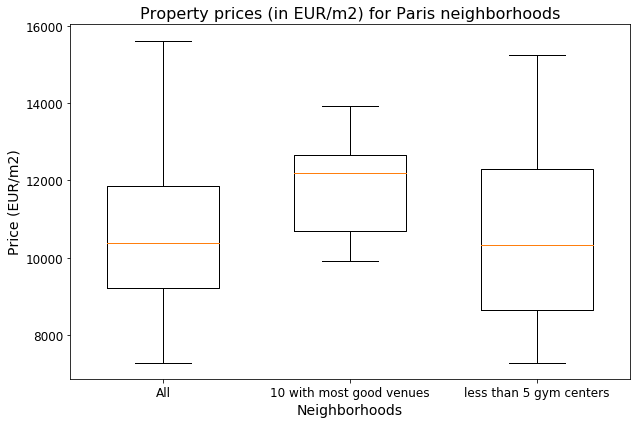

In [104]:
fig=plt.figure(figsize=(9,6))

X = [1,2,3]
labels = ['All', '10 with most good venues', 'less than 5 gym centers']
W=.6

plt.boxplot([df_paris['Price (EUR/m2)'], 
             df_paris[top_good_venues]['Price (EUR/m2)'],
             df_paris[less_gym_centers]['Price (EUR/m2)']], 
            showfliers=True, widths=W)
plt.xticks(ticks=X, labels=labels, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Neighborhoods', fontsize=14)
plt.ylabel('Price (EUR/m2)', fontsize=14)
plt.title('Property prices (in EUR/m2) for Paris neighborhoods', fontsize=16)
plt.tight_layout()
plt.savefig('Venues and prices bar chart.png')

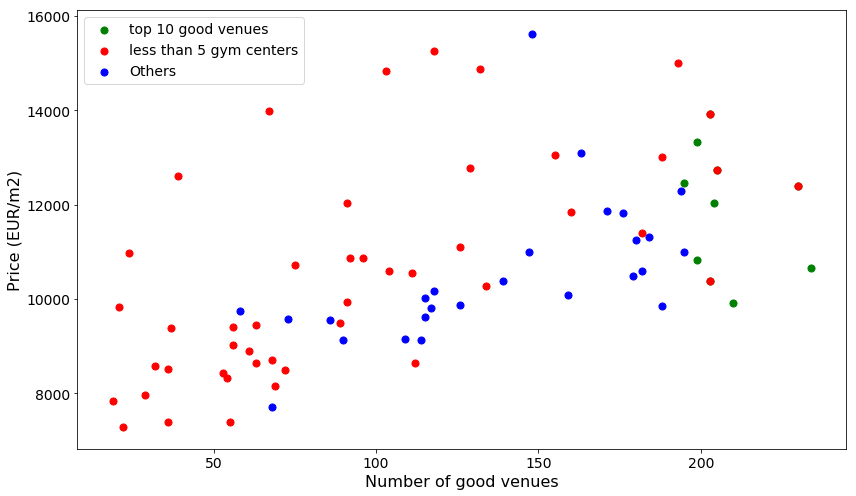

In [105]:
fig=plt.figure(figsize=(12,7))

top1 = top_good_venues(df_paris)
top2 = less_gym_centers(df_paris)
others = [not i for i in [a+b for a,b in zip(top1,top2)]]

plt.scatter(x=df_paris[top1]['Good Venues'],
            y=df_paris[top1]['Price (EUR/m2)'],
            s=50, c='g', label='top 10 good venues')
plt.scatter(x=df_paris[top2]['Good Venues'],
            y=df_paris[top2]['Price (EUR/m2)'],
            s=50, c='r', label='less than 5 gym centers')
plt.scatter(x=df_paris[others]['Good Venues'],
            y=df_paris[others]['Price (EUR/m2)'],
            s=50, c='b', label='Others')

plt.xlabel('Number of good venues', fontsize=16)
plt.ylabel('Price (EUR/m2)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.tight_layout()
plt.savefig('Venues and prices scatter.png')

In [76]:
df_paris[df_paris['Food']==100].Food.count()

16

{{df_paris[df_paris['Food']==100].Food.count()}} neighborhoods have the maximum number of food venues

In [77]:
best_venues = pd.DataFrame(columns=['Food', 'Hotel','Outdoors','Gym / Fitness Center',
                                    'Food & Drink Shop','Sporting Goods Shop'],
                           index=['1st', '2nd', '3rd', '4th', '5th',
                                  '6th', '7th', '8th', '9th', '10th',
                                  '11th', '12th', '13th', '14th', '15th',
                                  '16th'])

best_venues.loc[:,'Food'] = list(df_paris.sort_values(by='Food', 
                                                      ascending=False).Neighborhood[:16])
best_venues.loc[:,'Hotel'] = list(df_paris.sort_values(by='Hotel', 
                                                       ascending=False).Neighborhood[:16])
best_venues.loc[:,'Outdoors'] = list(df_paris.sort_values(by='Outdoors', 
                                                          ascending=False).Neighborhood[:16])
best_venues.loc[:,'Gym / Fitness Center'] = list(df_paris.sort_values(by='Gym / Fitness Center',
                                                                      ascending=True).Neighborhood[:16])
best_venues.loc[:,'Food & Drink Shop'] = list(df_paris.sort_values(by='Food & Drink Shop', 
                                                                   ascending=False).Neighborhood[:16])
best_venues.loc[:,'Sporting Goods Shop'] = list(df_paris.sort_values(by='Sporting Goods Shop', 
                                                                     ascending=False).Neighborhood[:16])
best_venues.loc[:,'Price'] = list(df_paris.sort_values(by='Price (EUR/m2)', 
                                                       ascending=True).Neighborhood[:16])

best_venues

Food                   Hotel                Outdoors  \
1st                 Vivienne     Faubourg-Montmartre           Saint-Gervais   
2nd            Saint-Gervais            Rochechouart              Notre-Dame   
3rd                     Mail                Sorbonne                Archives   
4th    Notre-Dame-des-Champs           Saint-Georges                 Arsenal   
5th             Palais-Royal           Place-Vendome          Champs-Elysees   
6th             Gros-Caillou       Porte-Saint-Denis                Sorbonne   
7th            Place-Vendome               Madeleine                 Monnaie   
8th      Faubourg-Montmartre                 Monnaie             Saint-Merri   
9th                  Monnaie                Vivienne            Saint-Victor   
10th  Saint-Germain-des-Pres        Chaussee-d'Antin      Jardin-des-Plantes   
11th          Enfants-Rouges            Palais-Royal    Saint-Thomas-d'Aquin   
12th                Archives  Saint-Germain-des-Pres     Hopital-Saint-Louis   
13th            Saint-Victor   Saint-Vincent-de-Paul  Saint-Germain-des-Pres   
14th         Arts-et-Metiers      Porte-Saint-Martin                Grenelle   
15th                Sorbonne                  Halles          Maison-Blanche   
16th          Bonne-Nouvelle         Arts-et-Metiers         Ecole-Militaire   

       Gym / Fitness Center    Food & Drink Shop     Sporting Goods Shop  \
1st                   Odeon       Bonne-Nouvelle                  Halles   
2nd           Saint-Gervais      Folie-Mericourt             Saint-Merri   
3rd              Belleville    Porte-Saint-Denis                Archives   
4th                 Monnaie                 Mail                 Monnaie   
5th                  Europe       Enfants-Rouges           Saint-Gervais   
6th      Parc-de-Montsouris               Halles  Saint-Germain-des-Pres   
7th      Plaine-de-Monceaux         Sainte-Avoye          Enfants-Rouges   
8th               Invalides             Archives           Place-Vendome   
9th           Saint-Fargeau         Clignancourt                Sorbonne   
10th               Chapelle   Porte-Saint-Martin                 Arsenal   
11th           Saint-Victor         Rochechouart           Saint-Georges   
12th  Saint-Vincent-de-Paul        Saint-Gervais         Folie-Mericourt   
13th               Archives             Sorbonne        Chaussee-d'Antin   
14th         Porte-Dauphine          Saint-Merri      Porte-Saint-Martin   
15th        Pont-de-Flandre      Arts-et-Metiers          Saint-Ambroise   
16th   Saint-Thomas-d'Aquin  Faubourg-Montmartre       Faubourg-du-Roule   

                      Price  
1st                Chapelle  
2nd         Pont-de-Flandre  
3rd             Goutte-d'Or  
4th                Villette  
5th                Amerique  
6th           Saint-Fargeau  
7th                    Gare  
8th                Charonne  
9th          Maison-Blanche  
10th             Belleville  
11th                 Combat  
12th                Bel-Air  
13th  Saint-Vincent-de-Paul  
14th          Pere-Lachaise  
15th                  Bercy  
16th                 Picpus

###### Count the occurences in the "best_venues" data frame

In [78]:
from collections import Counter
import operator
counts = Counter(best_venues.Food) + Counter(best_venues.Hotel) + Counter(best_venues.Outdoors) +\
Counter(best_venues['Gym / Fitness Center']) + Counter(best_venues['Food & Drink Shop']) +\
Counter(best_venues['Sporting Goods Shop']) + Counter(best_venues.Price)
sorted(counts.items(), key=operator.itemgetter(1), reverse=True)

[('Saint-Gervais', 5),
 ('Monnaie', 5),
 ('Archives', 5),
 ('Sorbonne', 5),
 ('Saint-Germain-des-Pres', 4),
 ('Place-Vendome', 3),
 ('Faubourg-Montmartre', 3),
 ('Enfants-Rouges', 3),
 ('Saint-Victor', 3),
 ('Arts-et-Metiers', 3),
 ('Saint-Vincent-de-Paul', 3),
 ('Porte-Saint-Martin', 3),
 ('Halles', 3),
 ('Saint-Merri', 3),
 ('Vivienne', 2),
 ('Mail', 2),
 ('Palais-Royal', 2),
 ('Bonne-Nouvelle', 2),
 ('Rochechouart', 2),
 ('Saint-Georges', 2),
 ('Porte-Saint-Denis', 2),
 ("Chaussee-d'Antin", 2),
 ('Arsenal', 2),
 ("Saint-Thomas-d'Aquin", 2),
 ('Maison-Blanche', 2),
 ('Belleville', 2),
 ('Saint-Fargeau', 2),
 ('Chapelle', 2),
 ('Pont-de-Flandre', 2),
 ('Folie-Mericourt', 2),
 ('Notre-Dame-des-Champs', 1),
 ('Gros-Caillou', 1),
 ('Madeleine', 1),
 ('Notre-Dame', 1),
 ('Champs-Elysees', 1),
 ('Jardin-des-Plantes', 1),
 ('Hopital-Saint-Louis', 1),
 ('Grenelle', 1),
 ('Ecole-Militaire', 1),
 ('Odeon', 1),
 ('Europe', 1),
 ('Parc-de-Montsouris', 1),
 ('Plaine-de-Monceaux', 1),
 ('Invalides

# Results

## Number of venues

###### Number of good venues

20 neighborhoods


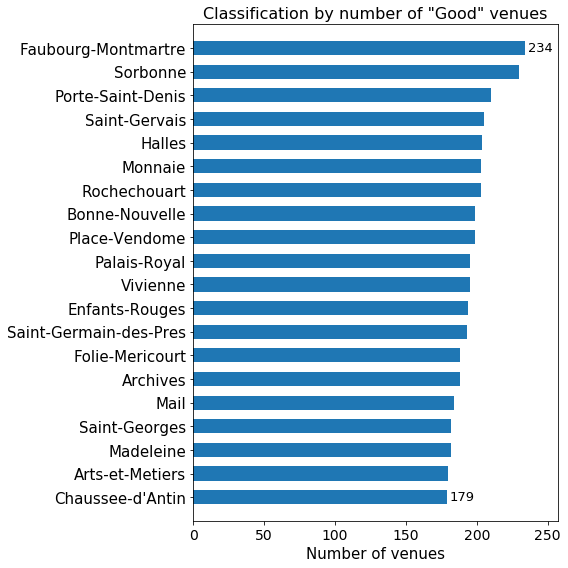

In [143]:
fig=plt.figure(figsize=(8,8))

W = df_paris['Good Venues'].sort_values(ascending=True).tail(20)

print('%s neighborhoods' %len(W))

labels_good = df_paris.sort_values(by='Good Venues', ascending=True).Neighborhood.tail(len(W))
X = np.arange(len(labels_good))

H=.6

rects = plt.barh(y=X, width=W, height=H)

plt.ylim(-1,len(X))
plt.xlim(0,1.1*df_paris['Good Venues'].max())
plt.yticks(ticks=X, labels=labels_good, fontsize=15)
plt.xticks(fontsize=14)
plt.title('Classification by number of "Good" venues', fontsize=16)
plt.xlabel('Number of venues', fontsize=15)

# Add text for 1st and last neighborhoods
plt.text(rects[0].get_width()*1.01, 
         rects[0].get_y()+rects[0].get_height()/2.0,
         '%d' %rects[0].get_width(),
         va='center', ha='left', fontsize=13)

plt.text(rects[-1].get_width()*1.01, 
         rects[-1].get_y()+rects[-1].get_height()/2.0,
         '%d' %rects[-1].get_width(),
         va='center', ha='left', fontsize=13)

plt.tight_layout()

###### Number of gym/fitness centers

29 neighborhoods


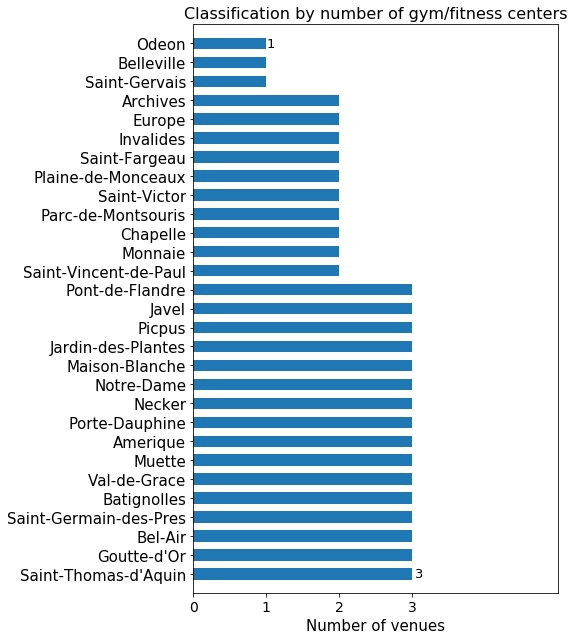

In [218]:
fig=plt.figure(figsize=(8,9))

W = df_paris['Gym / Fitness Center'].sort_values(ascending=False)[
    df_paris['Gym / Fitness Center']<4]

print('%s neighborhoods' %len(W))

labels_gym = df_paris.sort_values(by='Gym / Fitness Center', ascending=False).Neighborhood.tail(len(W))
X = np.arange(len(labels_gym))

H=.6

rects = plt.barh(y=X, width=W, height=H)

plt.ylim(-1,len(X))
plt.xlim(0,5)
plt.yticks(ticks=X, labels=labels_gym, fontsize=15)
plt.xticks(ticks=[0,1,2,3], fontsize=14)
plt.title('Classification by number of gym/fitness centers', fontsize=16)
plt.xlabel('Number of venues', fontsize=15)

# Add text for 1st and last neighborhoods
plt.text(rects[0].get_width()*1.01, 
         rects[0].get_y()+rects[0].get_height()/2.0,
         '%d' %rects[0].get_width(),
         va='center', ha='left', fontsize=13)

plt.text(rects[-1].get_width()*1.01, 
         rects[-1].get_y()+rects[-1].get_height()/2.0,
         '%d' %rects[-1].get_width(),
         va='center', ha='left', fontsize=13)

plt.tight_layout()

###### Map

In [141]:
# + / - 0.1 to prevent error
scale = [df_paris['Good Venues'].min()-.1,
         df_paris['Good Venues'].sort_values(ascending=False).iloc[19],
         df_paris['Good Venues'].max()+.1]

paris_venues_map = folium.Map(location=[paris_latitude, paris_longitude], 
                       zoom_start=12, tiles='cartodbpositron')
paris_venues_map.choropleth(
    geo_data=neigh_json,
    data= df_paris,
    columns=['Neighborhood', 'Good Venues'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name= 'Number of "good" venues',
    threshold_scale=scale
)

for arrt, neigh, lat, lng, venue in zip(df_paris.Arrondissement,
                                        df_paris.Neighborhood,
                                        df_paris.Latitude, 
                                        df_paris.Longitude,
                                        df_paris['Good Venues']):
    label = '%s, %se arrt'%(neigh, arrt)
    label = folium.Popup(label, parse_html=True)
    if neigh in labels_gym.to_list():
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(paris_venues_map)  
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(paris_venues_map)  
    
paris_venues_map.save("Paris_venues_map.html")

paris_venues_map

###### Intersection of the lists

In [144]:
set(labels_good).intersection(set(labels_gym))

{'Archives', 'Monnaie', 'Saint-Germain-des-Pres', 'Saint-Gervais'}

## Venues to prices ratio

###### Create data frames

In [112]:
df_paris_ratio = pd.DataFrame()
df_paris_ratio['Neighborhood'] = df_paris.Neighborhood
df_paris_ratio['Good Venues'] = df_paris['Good Venues']/(0.0001*df_paris['Price (EUR/m2)'])
df_paris_ratio['Gym / Fitness Center'] = df_paris['Gym / Fitness Center']*(0.0001*df_paris['Price (EUR/m2)'])
df_paris_ratio.head()

Neighborhood  Good Venues  Gym / Fitness Center
0         Amerique    24.222336                2.3532
1         Archives   144.426519                2.6034
2          Arsenal   100.931070                5.1124
3  Arts-et-Metiers   159.928920                9.0040
4          Auteuil    59.505489                4.8735

###### Number of good venues

20 neighborhoods


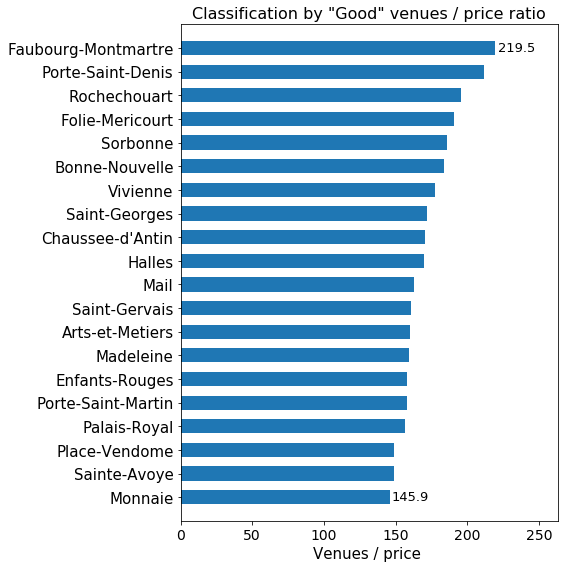

In [145]:
fig=plt.figure(figsize=(8,8))

W = df_paris_ratio['Good Venues'].sort_values(ascending=True).tail(20)

print('%s neighborhoods' %len(W))

labels_good = df_paris_ratio.sort_values(by='Good Venues', ascending=True).Neighborhood.tail(len(W))
X = np.arange(len(labels_good))

H=.6

rects = plt.barh(y=X, width=W, height=H)

plt.ylim(-1,len(X))
plt.xlim(0,1.2*df_paris_ratio['Good Venues'].max())
plt.yticks(ticks=X, labels=labels_good, fontsize=15)
plt.xticks(fontsize=14)
plt.title('Classification by "Good" venues / price ratio', fontsize=16)
plt.xlabel('Venues / price ', fontsize=15)

# Add text for 1st and last neighborhoods
plt.text(rects[0].get_width()*1.01, 
         rects[0].get_y()+rects[0].get_height()/2.0,
         '%.1f' %rects[0].get_width(),
         va='center', ha='left', fontsize=13)

plt.text(rects[-1].get_width()*1.01, 
         rects[-1].get_y()+rects[-1].get_height()/2.0,
         '%.1f' %rects[-1].get_width(),
         va='center', ha='left', fontsize=13)

plt.tight_layout() 

###### Map

In [219]:
# + / - 0.1 to prevent error
scale = [df_paris_ratio['Good Venues'].min()-.1,
         df_paris_ratio['Good Venues'].sort_values(ascending=False).iloc[19],
         df_paris_ratio['Good Venues'].max()+.1]

paris_venues_map2 = folium.Map(location=[paris_latitude, paris_longitude], 
                       zoom_start=12, tiles='cartodbpositron')
paris_venues_map2.choropleth(
    geo_data=neigh_json,
    data= df_paris_ratio,
    columns=['Neighborhood', 'Good Venues'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name= 'Good Venues / 0.0001*price',
    threshold_scale=scale
)

for arrt, neigh, lat, lng in zip(df_paris.Arrondissement,
                                 df_paris.Neighborhood,
                                 df_paris.Latitude, 
                                 df_paris.Longitude):
    label = '%s, %se arrt'%(neigh, arrt)
    label = folium.Popup(label, parse_html=True)
    if neigh in labels_gym.to_list():
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(paris_venues_map2)  
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(paris_venues_map2)  
    
paris_venues_map2.save("Paris_venues_map2.html")

paris_venues_map2

###### Intersection of the lists

In [156]:
set(labels_good).intersection(set(labels_gym))

{'Monnaie', 'Saint-Gervais'}

## Average rank of Paris neighborhoods

###### Create rankings data frames

In [157]:
df_paris.columns

Index(['Neighborhood', 'Price (EUR/m2)', 'Arrondissement', 'Latitude',
       'Longitude', 'Food', 'Hotel', 'Outdoors', 'Gym / Fitness Center',
       'Food & Drink Shop', 'Sporting Goods Shop', 'Good Venues'],
      dtype='object')

In [159]:
food_rank=df_paris.sort_values(by='Food',
                               ascending=False).reset_index(drop=True).Neighborhood.to_frame()
price_rank=df_paris.sort_values(by='Price (EUR/m2)',
                                ascending=True).reset_index(drop=True).Neighborhood.to_frame()
hotel_rank=df_paris.sort_values(by='Hotel',
                                ascending=False).reset_index(drop=True).Neighborhood.to_frame()
outdoors_rank=df_paris.sort_values(by='Outdoors',
                                   ascending=False).reset_index(drop=True).Neighborhood.to_frame()
gym_rank=df_paris.sort_values(by='Gym / Fitness Center',
                              ascending=True).reset_index(drop=True).Neighborhood.to_frame()
shop_rank=df_paris.sort_values(by='Food & Drink Shop',
                               ascending=False).reset_index(drop=True).Neighborhood.to_frame()
sport_rank=df_paris.sort_values(by='Sporting Goods Shop',
                                ascending=False).reset_index(drop=True).Neighborhood.to_frame()

###### Add rank column in paris data frame

In [160]:
# Initiate rank column
df_paris['Rank']=df_paris.index

# Calculate average rank for each neighborhood
for neigh in df_paris.Neighborhood:
    df_paris.loc[df_paris.Neighborhood==neigh,'Rank']= int(round(np.mean((
        food_rank[food_rank.Neighborhood==neigh].index[0],
        price_rank[price_rank.Neighborhood==neigh].index[0],
        hotel_rank[hotel_rank.Neighborhood==neigh].index[0],
        outdoors_rank[outdoors_rank.Neighborhood==neigh].index[0],
        gym_rank[gym_rank.Neighborhood==neigh].index[0],
        shop_rank[shop_rank.Neighborhood==neigh].index[0],
        sport_rank[sport_rank.Neighborhood==neigh].index[0]))))
         
    
df_paris.head()

Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  Good Venues  Rank  
0                    0           19    55  
1                    8          188    19  
2                    6          129    34  
3                    1          180    36  
4                    1           58    54

###### Display best neighborhoods

21 neighborhoods


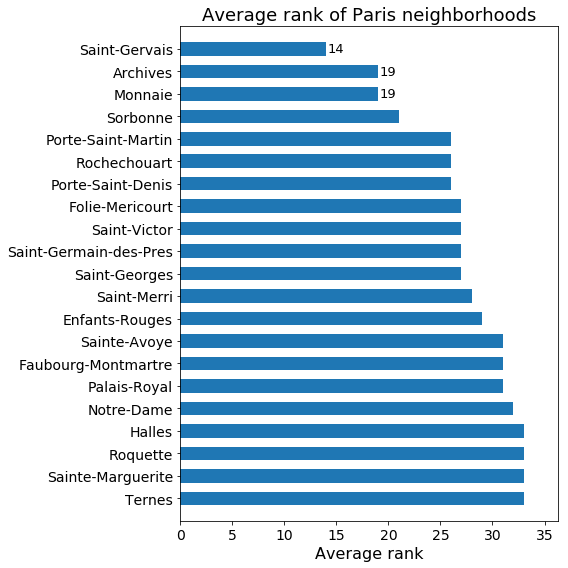

In [162]:
fig=plt.figure(figsize=(8,8))

W=df_paris.Rank.sort_values(ascending=False)[df_paris.Rank.sort_values(ascending=False)<34]

print('%s neighborhoods' %len(W))

H=0.6

labels=df_paris.sort_values(by='Rank', ascending=False).Neighborhood.tail(len(W))

Y=np.arange(len(labels))

rects = plt.barh(y=Y, width=W, height=H)
plt.xlabel(xlabel='Average rank', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(ticks=Y, labels=labels, fontsize=14)
plt.ylim(-1, len(labels))
plt.xlim(0, W.iloc[0]*1.1)

# Add text on 1st neighborhood
for i in [-1, -2, -3]:
    plt.text(rects[i].get_width()*1.01, 
             rects[i].get_y()+rects[i].get_height()/2.0,
             '%d' %rects[i].get_width(),
             va='center', ha='left', fontsize=13)

plt.title('Average rank of Paris neighborhoods', fontsize=18)
plt.tight_layout()
plt.savefig('average rank best neighborhoods.png')

## Score

### Balanced

###### Create a score column

In [236]:
df_paris['Score balanced']= df_paris['Good Venues']/5 - df_paris['Gym / Fitness Center']
df_paris.head()

Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  Good Venues  Rank  Score balanced  \
0                    0           19    55             0.8   
1                    8          188    19            35.6   
2                    6          129    34            21.8   
3                    1          180    36            28.0   
4                    1           58    54             6.6   

   Score balanced / price  Score weighted  Score weighted / price  Cluster  
0                     4.8             4.5                5.736869        1  
1                    28.9            47.4               36.413920        3  
2                    20.2            33.3               26.054299        3  
3                    32.0            48.8               43.358507        2  
4                    11.9            15.0               15.389351        1

###### Display on bar chart

20 neighborhoods


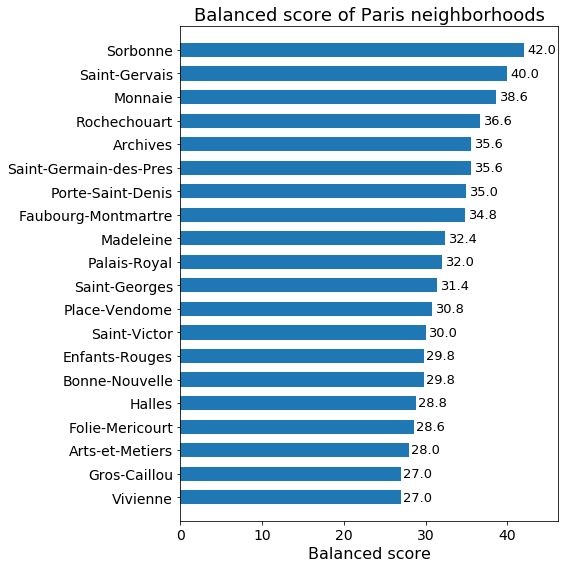

In [237]:
fig=plt.figure(figsize=(8,8))

W=df_paris['Score balanced'].sort_values(ascending=True).tail(20)

print('%s neighborhoods' %len(W))

H=0.6

labels_score=df_paris.sort_values(by='Score balanced', ascending=True).Neighborhood.tail(len(W))

Y=np.arange(len(labels_score))

rects = plt.barh(y=Y, width=W, height=H)
plt.xlabel(xlabel='Balanced score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(ticks=Y, labels=labels_score, fontsize=14)
plt.ylim(-1, len(labels_score))
plt.xlim(0, W.iloc[-1]*1.1)

# Add text on 1st neighborhood
for i in Y:
    plt.text(rects[i].get_width()*1.01, 
             rects[i].get_y()+rects[i].get_height()/2.0,
             '%.1f' %rects[i].get_width(),
             va='center', ha='left', fontsize=13)

plt.title('Balanced score of Paris neighborhoods', fontsize=18)
plt.tight_layout()
plt.savefig('balanced scores.png')

###### Create score / price column

In [238]:
df_paris['Score balanced / price']= round(
    df_paris['Score balanced'] / (0.0001*df_paris['Price (EUR/m2)']) ,1)
df_paris.head()

Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  Good Venues  Rank  Score balanced  \
0                    0           19    55             0.8   
1                    8          188    19            35.6   
2                    6          129    34            21.8   
3                    1          180    36            28.0   
4                    1           58    54             6.6   

   Score balanced / price  Score weighted  Score weighted / price  Cluster  
0                     1.0             4.5                5.736869        1  
1                    27.3            47.4               36.413920        3  
2                    17.1            33.3               26.054299        3  
3                    24.9            48.8               43.358507        2  
4                     6.8            15.0               15.389351        1

###### Display on bar chart

20 neighborhoods


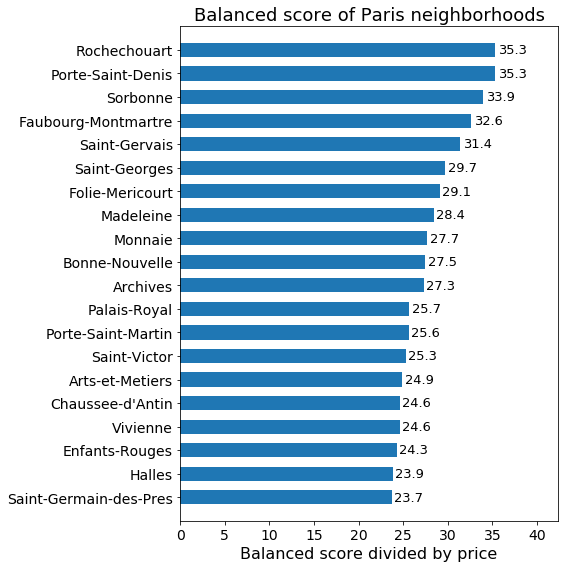

In [239]:
fig=plt.figure(figsize=(8,8))
W=df_paris['Score balanced / price'].sort_values(ascending=True).tail(20)

print('%s neighborhoods' %len(W))

H=0.6

labels_score_price=df_paris.sort_values(by='Score balanced / price', ascending=True).Neighborhood.tail(len(W))

Y=np.arange(len(labels_score_price))

rects = plt.barh(y=Y, width=W, height=H)
plt.xlabel(xlabel='Balanced score divided by price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(ticks=Y, labels=labels_score_price, fontsize=14)
plt.ylim(-1, len(labels_score_price))
plt.xlim(0, W.iloc[-1]*1.2)

# Add text on 1st neighborhood
for i in Y:
    plt.text(rects[i].get_width()*1.01, 
             rects[i].get_y()+rects[i].get_height()/2.0,
             '%.1f' %rects[i].get_width(),
             va='center', ha='left', fontsize=13)

plt.title('Balanced score of Paris neighborhoods', fontsize=18)
plt.tight_layout()
plt.savefig('balanced scores price.png')

###### Map

In [242]:
# + / - 0.1 to prevent error
scale = [df_paris['Score balanced / price'].min()-.1,
         df_paris['Score balanced / price'].sort_values(ascending=False).iloc[19],
         df_paris['Score balanced / price'].max()+.1]

balanced_scores_map = folium.Map(location=[paris_latitude, paris_longitude], 
                       zoom_start=12, tiles='cartodbpositron')
balanced_scores_map.choropleth(
    geo_data=neigh_json,
    data= df_paris,
    columns=['Neighborhood', 'Score balanced / price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name= 'Score balanced / price'
)

for arrt, neigh, lat, lng, venue in zip(df_paris.Arrondissement,
                                        df_paris.Neighborhood,
                                        df_paris.Latitude, 
                                        df_paris.Longitude,
                                        df_paris['Good Venues']):
    label = '%s, %se arrt'%(neigh, arrt)
    label = folium.Popup(label, parse_html=True)
    if neigh in labels_gym.to_list():
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(balanced_scores_map)  
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(balanced_scores_map)  
    
balanced_scores_map.save("Balanced_scores_map.html")

balanced_scores_map

###### Intersection

In [241]:
set(labels_score).intersection(set(labels_score_price))

{'Archives',
 'Arts-et-Metiers',
 'Bonne-Nouvelle',
 'Enfants-Rouges',
 'Faubourg-Montmartre',
 'Folie-Mericourt',
 'Halles',
 'Madeleine',
 'Monnaie',
 'Palais-Royal',
 'Porte-Saint-Denis',
 'Rochechouart',
 'Saint-Georges',
 'Saint-Germain-des-Pres',
 'Saint-Gervais',
 'Saint-Victor',
 'Sorbonne',
 'Vivienne'}

### Weighted

###### Create score 

In [243]:
df_paris['Score weighted']=round(((
    3*df_paris['Food'] + 3*df_paris['Hotel'] +
    1.5*df_paris['Outdoors']+ 1.5*df_paris['Food & Drink Shop'] + 
    1*df_paris['Sporting Goods Shop'] ) / (3+3+1.5+1.5+1)) - df_paris['Gym / Fitness Center'],1)
                                                                     
df_paris.head()

Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  Good Venues  Rank  Score balanced  \
0                    0           19    55             0.8   
1                    8          188    19            35.6   
2                    6          129    34            21.8   
3                    1          180    36            28.0   
4                    1           58    54             6.6   

   Score balanced / price  Score weighted  Score weighted / price  Cluster  
0                     1.0             1.5                5.736869        1  
1                    27.3            45.4               36.413920        3  
2                    17.1            29.3               26.054299        3  
3                    24.9            40.8               43.358507        2  
4                     6.8            10.0               15.389351        1

###### Display on bar chart

20 neighborhoods


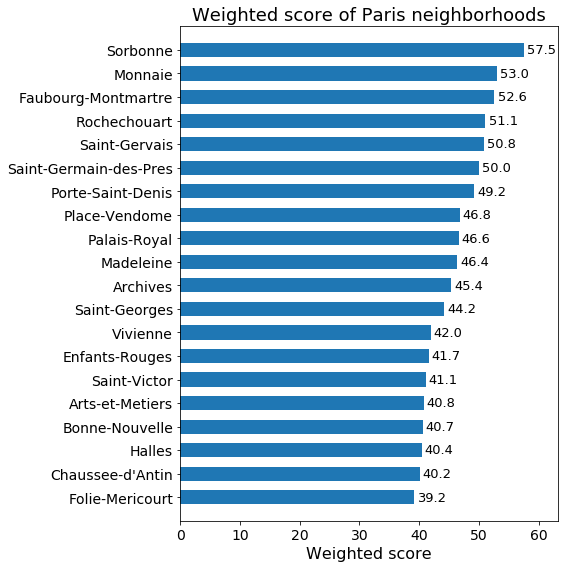

In [244]:
fig=plt.figure(figsize=(8,8))

W=df_paris['Score weighted'].sort_values(ascending=True).tail(20)

print('%s neighborhoods' %len(W))

H=0.6

labels_score=df_paris.sort_values(by='Score weighted', ascending=True).Neighborhood.tail(len(W))

Y=np.arange(len(labels_score))

rects = plt.barh(y=Y, width=W, height=H)
plt.xlabel(xlabel='Weighted score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(ticks=Y, labels=labels_score, fontsize=14)
plt.ylim(-1, len(labels_score))
plt.xlim(0, W.iloc[-1]*1.1)

# Add text on 1st neighborhood
for i in Y:
    plt.text(rects[i].get_width()*1.01, 
             rects[i].get_y()+rects[i].get_height()/2.0,
             '%.1f' %rects[i].get_width(),
             va='center', ha='left', fontsize=13)

plt.title('Weighted score of Paris neighborhoods', fontsize=18)
plt.tight_layout()
plt.savefig('weighted scores.png')

###### Create score / price column

In [245]:
df_paris['Score weighted / price']= df_paris['Score weighted'] / (0.0001*df_paris['Price (EUR/m2)'])
df_paris.head()

Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  Good Venues  Rank  Score balanced  \
0                    0           19    55             0.8   
1                    8          188    19            35.6   
2                    6          129    34            21.8   
3                    1          180    36            28.0   
4                    1           58    54             6.6   

   Score balanced / price  Score weighted  Score weighted / price  Cluster  
0                     1.0             1.5                1.912290        1  
1                    27.3            45.4               34.877468        3  
2                    17.1            29.3               22.924654        3  
3                    24.9            40.8               36.250555        2  
4                     6.8            10.0               10.259567        1

###### Display on bar chart

20 neighborhoods


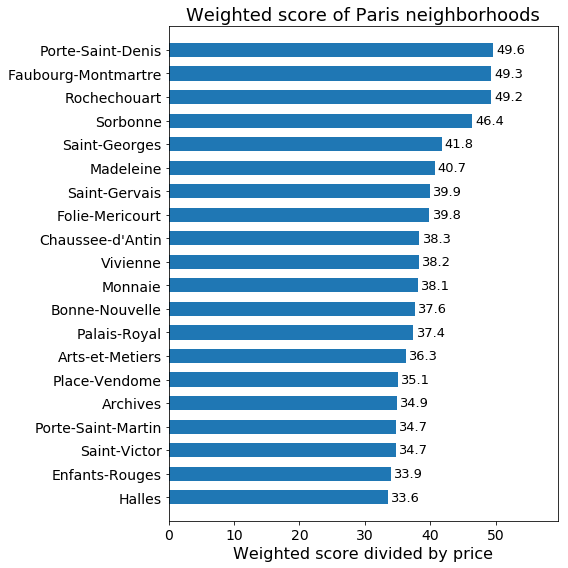

In [246]:
fig=plt.figure(figsize=(8,8))

W=df_paris['Score weighted / price'].sort_values(ascending=True).tail(20)

print('%s neighborhoods' %len(W))

H=0.6

labels_score_price=df_paris.sort_values(by='Score weighted / price', ascending=True).Neighborhood.tail(len(W))

Y=np.arange(len(labels_score_price))

rects = plt.barh(y=Y, width=W, height=H)
plt.xlabel(xlabel='Weighted score divided by price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(ticks=Y, labels=labels_score_price, fontsize=14)
plt.ylim(-1, len(labels_score_price))
plt.xlim(0, W.iloc[-1]*1.2)

# Add text on 1st neighborhood
for i in Y:
    plt.text(rects[i].get_width()*1.01, 
             rects[i].get_y()+rects[i].get_height()/2.0,
             '%.1f' %rects[i].get_width(),
             va='center', ha='left', fontsize=13)

plt.title('Weighted score of Paris neighborhoods', fontsize=18)
plt.tight_layout()
plt.savefig('weighted scores price.png')

###### Map

In [248]:
# + / - 0.1 to prevent error
scale = [df_paris['Score weighted / price'].min()-.1,
         df_paris['Score weighted / price'].sort_values(ascending=False).iloc[19],
         df_paris['Score weighted / price'].max()+.1]

weighted_scores_map = folium.Map(location=[paris_latitude, paris_longitude], 
                       zoom_start=12, tiles='cartodbpositron')
weighted_scores_map.choropleth(
    geo_data=neigh_json,
    data= df_paris,
    columns=['Neighborhood', 'Score weighted / price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name= 'Score weighted / price'
)

for arrt, neigh, lat, lng, venue in zip(df_paris.Arrondissement,
                                        df_paris.Neighborhood,
                                        df_paris.Latitude, 
                                        df_paris.Longitude,
                                        df_paris['Good Venues']):
    label = '%s, %se arrt'%(neigh, arrt)
    label = folium.Popup(label, parse_html=True)
    if neigh in labels_gym.to_list():
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(weighted_scores_map)  
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(weighted_scores_map)  
    
weighted_scores_map.save("Weighted_scores_map.html")

weighted_scores_map

###### Interserction

In [1229]:
set(labels_score).intersection(set(labels_score_price))

{'Chaillot',
 'Faubourg-Montmartre',
 'Madeleine',
 'Monnaie',
 'Palais-Royal',
 'Place-Vendome',
 'Porte-Saint-Denis',
 'Rochechouart',
 'Saint-Germain-des-Pres',
 'Saint-Gervais',
 'Saint-Merri',
 'Saint-Victor',
 'Sorbonne'}

###### Most common venues of best neighborhood

In [249]:
top20 = labels_score_price
paris_common_venues.loc[top20, :]

1st                     2nd                     3rd  \
Neighborhood                                                                    
Halles               47 Hotel    28 French Restaurant          15 Supermarket   
Enfants-Rouges       46 Hotel    14 French Restaurant            14 Wine Shop   
Saint-Victor         27 Hotel    27 French Restaurant   10 Italian Restaurant   
Porte-Saint-Martin   53 Hotel          15 Supermarket    11 French Restaurant   
Archives             30 Hotel    22 French Restaurant            11 Wine Shop   
Place-Vendome        72 Hotel    41 French Restaurant  10 Japanese Restaurant   
Arts-et-Metiers      46 Hotel    19 French Restaurant          11 Supermarket   
Palais-Royal         58 Hotel  18 Japanese Restaurant    17 French Restaurant   
Bonne-Nouvelle       39 Hotel    19 French Restaurant          18 Supermarket   
Monnaie              63 Hotel    33 French Restaurant    9 Italian Restaurant   
Vivienne             62 Hotel    24 French Restaurant  13 Japanese Restaurant   
Chaussee-d'Antin     61 Hotel    20 French Restaurant    9 Italian Restaurant   
Folie-Mericourt      34 Hotel    22 French Restaurant          14 Supermarket   
Saint-Gervais        40 Hotel    31 French Restaurant               12 Garden   
Madeleine            65 Hotel    29 French Restaurant    8 Italian Restaurant   
Saint-Georges        77 Hotel    15 French Restaurant           9 Supermarket   
Sorbonne             81 Hotel    23 French Restaurant          11 Supermarket   
Rochechouart         76 Hotel    26 French Restaurant          13 Supermarket   
Faubourg-Montmartre  96 Hotel    23 French Restaurant          14 Supermarket   
Porte-Saint-Denis    67 Hotel    21 French Restaurant          13 Supermarket   

                                        4th                    5th  \
Neighborhood                                                         
Halles               13 Sporting Goods Shop               9 Bakery   
Enfants-Rouges                      10 Café          8 Supermarket   
Saint-Victor                       7 Bakery                 7 Café   
Porte-Saint-Martin          6 Grocery Store               4 Bistro   
Archives              8 Sporting Goods Shop           8 Restaurant   
Place-Vendome              7 Sandwich Place  6 Sporting Goods Shop   
Arts-et-Metiers                 7 Wine Shop           6 Restaurant   
Palais-Royal                  9 Supermarket                 8 Café   
Bonne-Nouvelle              9 Grocery Store            7 Wine Shop   
Monnaie               7 Sporting Goods Shop            6 Wine Shop   
Vivienne                     13 Supermarket            7 Wine Shop   
Chaussee-d'Antin              8 Salad Place       7 Sandwich Place   
Folie-Mericourt                9 Restaurant            9 Wine Shop   
Saint-Gervais                   9 Wine Shop         9 Gourmet Shop   
Madeleine                       7 Wine Shop         6 Gourmet Shop   
Saint-Georges          7 Italian Restaurant        6 Grocery Store   
Sorbonne                            11 Café           10 Wine Shop   
Rochechouart                       9 Bakery        8 Grocery Store   
Faubourg-Montmartre  7 Gym / Fitness Center         6 Burger Joint   
Porte-Saint-Denis           9 Grocery Store          7 Pizza Place   

                                        6th                      7th  \
Neighborhood                                                           
Halles                        8 Pizza Place                   7 Café   
Enfants-Rouges                     7 Bistro             7 Restaurant   
Saint-Victor                6 Grocery Store                 5 Bistro   
Porte-Saint-Martin   4 Gym / Fitness Center    4 Sporting Goods Shop   
Archives                             7 Park                 7 Garden   
Place-Vendome                 5 Supermarket      4 Korean Restaurant   
Arts-et-Metiers       5 Japanese Restaurant  5 Vietnamese Restaurant   
Palais-Royal           7 Italian Restaurant       7 Ra

## Clustering

In [177]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [178]:
df_paris.columns

Index(['Neighborhood', 'Price (EUR/m2)', 'Arrondissement', 'Latitude',
       'Longitude', 'Food', 'Hotel', 'Outdoors', 'Gym / Fitness Center',
       'Food & Drink Shop', 'Sporting Goods Shop', 'Good Venues', 'Rank',
       'Score balanced', 'Score balanced / price', 'Score weighted',
       'Score weighted / price'],
      dtype='object')

###### Apply clustering

In [250]:
kclusters=4
data=StandardScaler().fit_transform(
    df_paris.drop(['Neighborhood', 'Arrondissement', 'Latitude', 'Longitude', 'Good Venues',
                   'Rank', 'Score balanced', 'Score balanced / price',
                   'Score weighted', 'Score weighted / price'], axis=1)
)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data)
kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(paris_venues_grouped)
kmeans2.labels_

C:\Users\gklein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\gklein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([3, 1, 1, 2, 3, 1, 3, 3, 3, 2, 2, 1, 3, 3, 0, 1, 3, 3, 3, 2, 3, 1,
       0, 2, 2, 3, 3, 3, 2, 1, 2, 1, 1, 3, 3, 0, 2, 3, 0, 1, 3, 1, 1, 2,
       2, 0, 3, 3, 1, 3, 0, 1, 3, 3, 3, 0, 2, 2, 0, 1, 1, 3, 0, 0, 2, 3,
       2, 1, 1, 2, 2, 3, 3, 0, 1, 1, 3, 0])

In [251]:
df_paris['Cluster']=kmeans2.labels_
df_paris.head()

Neighborhood  Price (EUR/m2)  Arrondissement   Latitude  Longitude  \
0         Amerique            7844              19  48.881638   2.395440   
1         Archives           13017               3  48.859192   2.363205   
2          Arsenal           12781               4  48.851585   2.364768   
3  Arts-et-Metiers           11255               3  48.866470   2.357083   
4          Auteuil            9747              16  48.849118   2.265405   

   Food  Hotel  Outdoors  Gym / Fitness Center  Food & Drink Shop  \
0    10      1         1                     3                  7   
1   100     31        14                     2                 35   
2    64     31        12                     4                 16   
3   100     46         2                     8                 31   
4    39      3         0                     5                 15   

   Sporting Goods Shop  Good Venues  Rank  Score balanced  \
0                    0           19    55             0.8   
1                    8          188    19            35.6   
2                    6          129    34            21.8   
3                    1          180    36            28.0   
4                    1           58    54             6.6   

   Score balanced / price  Score weighted  Score weighted / price  Cluster  
0                     1.0             1.5                1.912290        3  
1                    27.3            45.4               34.877468        1  
2                    17.1            29.3               22.924654        1  
3                    24.9            40.8               36.250555        2  
4                     6.8            10.0               10.259567        3

###### display clusters on a map

In [252]:
import matplotlib.cm as cm
import matplotlib.colors as colors

scale = list(i for i in np.linspace(start=df_paris['Score weighted / price'].min()-.1,
                                    stop=df_paris['Score weighted / price'].max()+.1,
                                    num=5))
    
#scale = [df_paris['Score weighted / price'].min()-0.1, 
#         df_paris['Score weighted / price'].sort_values(ascending=False).iloc[19], 
#         df_paris['Score weighted / price'].max()+.1]

# create map
map_clusters = folium.Map(location=[paris_latitude, paris_longitude],
                          zoom_start=12, tiles='cartodbpositron')
map_clusters.choropleth(
    geo_data=neigh_json,
    data=df_paris,
    columns=['Neighborhood', 'Score weighted / price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name='Score weighted / price',
    threshold_scale=scale
)
# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.gnuplot(np.linspace(0, 1, len(x)))
cols = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster, name in zip(df_paris.Latitude, df_paris.Longitude, df_paris.Cluster,
                                         df_paris.Neighborhood):
    label = folium.Popup('%s: %d' %(name, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        label=label,
        color=cols[cluster-1],
        fill=True,
        fill_color=cols[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters.save('clusters.html')
map_clusters


###### define cluster data frames

In [253]:
clus0 = df_paris[df_paris.Cluster==0][['Neighborhood', 'Rank', 'Score balanced', 
                                       'Score balanced / price', 'Score weighted',
                                        'Score weighted / price']]
clus1 = df_paris[df_paris.Cluster==1][['Neighborhood', 'Rank', 'Score balanced', 
                                       'Score balanced / price', 'Score weighted',
                                        'Score weighted / price']]
clus2 = df_paris[df_paris.Cluster==2][['Neighborhood', 'Rank', 'Score balanced', 
                                       'Score balanced / price', 'Score weighted',
                                        'Score weighted / price']]
clus3 = df_paris[df_paris.Cluster==3][['Neighborhood', 'Rank', 'Score balanced', 
                                       'Score balanced / price', 'Score weighted',
                                        'Score weighted / price']]

In [254]:
set(top20).intersection(set(clus0.Neighborhood))

{"Chaussee-d'Antin",
 'Faubourg-Montmartre',
 'Madeleine',
 'Monnaie',
 'Palais-Royal',
 'Place-Vendome',
 'Porte-Saint-Denis',
 'Rochechouart',
 'Saint-Georges',
 'Sorbonne',
 'Vivienne'}

In [255]:
paris_common_venues.loc[clus0.Neighborhood, :]

1st                     2nd  \
Neighborhood                                               
Chaussee-d'Antin        61 Hotel    20 French Restaurant   
Faubourg-Montmartre     96 Hotel    23 French Restaurant   
Madeleine               65 Hotel    29 French Restaurant   
Monnaie                 63 Hotel    33 French Restaurant   
Palais-Royal            58 Hotel  18 Japanese Restaurant   
Place-Vendome           72 Hotel    41 French Restaurant   
Porte-Saint-Denis       67 Hotel    21 French Restaurant   
Rochechouart            76 Hotel    26 French Restaurant   
Saint-Georges           77 Hotel    15 French Restaurant   
Saint-Germain-des-Pres  61 Hotel    32 French Restaurant   
Sorbonne                81 Hotel    23 French Restaurant   
Vivienne                62 Hotel    24 French Restaurant   

                                           3rd                     4th  \
Neighborhood                                                             
Chaussee-d'Antin          9 Italian Restaurant           8 Salad Place   
Faubourg-Montmartre             14 Supermarket  7 Gym / Fitness Center   
Madeleine                 8 Italian Restaurant             7 Wine Shop   
Monnaie                   9 Italian Restaurant   7 Sporting Goods Shop   
Palais-Royal              17 French Restaurant           9 Supermarket   
Place-Vendome           10 Japanese Restaurant        7 Sandwich Place   
Porte-Saint-Denis               13 Supermarket         9 Grocery Store   
Rochechouart                    13 Supermarket                9 Bakery   
Saint-Georges                    9 Supermarket    7 Italian Restaurant   
Saint-Germain-des-Pres   14 Italian Restaurant                  8 Café   
Sorbonne                        11 Supermarket                 11 Café   
Vivienne                13 Japanese Restaurant          13 Supermarket   

                                          5th                    6th  \
Neighborhood                                                           
Chaussee-d'Antin             7 Sandwich Place               6 Bistro   
Faubourg-Montmartre            6 Burger Joint   5 Italian Restaurant   
Madeleine                      6 Gourmet Shop                 5 Café   
Monnaie                           6 Wine Shop               6 Bistro   
Palais-Royal                           8 Café   7 Italian Restaurant   
Place-Vendome           6 Sporting Goods Shop          5 Supermarket   
Porte-Saint-Denis               7 Pizza Place                 6 Café   
Rochechouart                  8 Grocery Store   7 Italian Restaurant   
Saint-Georges                 6 Grocery Store               5 Bistro   
Saint-Germain-des-Pres  7 Sporting Goods Shop                 6 Park   
Sorbonne                         10 Wine Shop  7 Japanese Restaurant   
Vivienne                          7 Wine Shop               6 Bistro   

                                           7th                    8th  \
Neighborhood                                                            
Chaussee-d'Antin                 6 Supermarket         5 Burger Joint   
Faubourg-Montmartre      5 Japanese Restaurant      5 Thai Restaurant   
Madeleine                   5 Asian Restaurant          5 Supermarket   
Monnaie                          6 Supermarket                 5 Café   
Palais-Royal                7 Ramen Restaurant               6 Bakery   
Place-Vendome              4 Korean Restaurant   4 Italian Restaurant   
Porte-Saint-Denis                  6 Wine Shop               5 Bistro   
Rochechouart                       6 Wine Shop  5 Japanese Restaurant   
Saint-Georges            5 Sporting Goods Shop            4 Wine Shop   
Saint-Germain-des-Pres   6 Japanese Restaurant            5 Wine Shop   
Sorbonne                              6 Bakery  6 Sporting Goods Shop   
Vivienne                5 Gym / Fitness Center          4 Salad Place   

                                                    9th  \
Neighborhood                                              
C

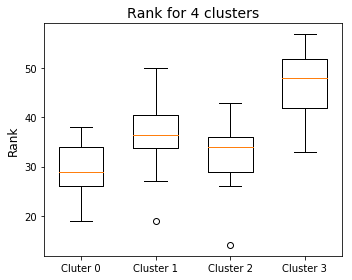

In [256]:
fig=plt.figure(figsize=(5,4))

X = [1,2,3,4]
labels = ['Cluter 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
W=.6
plt.boxplot([clus0.Rank, clus1.Rank, clus2.Rank, clus3.Rank], 
                 showfliers=True, widths=W)

plt.ylabel('Rank', fontsize=12)
plt.xticks(ticks=X, labels=labels)
plt.title('Rank for 4 clusters', fontsize=14)
plt.tight_layout()
plt.savefig('5.5_Boxplot_Cluster+Ranks.png')

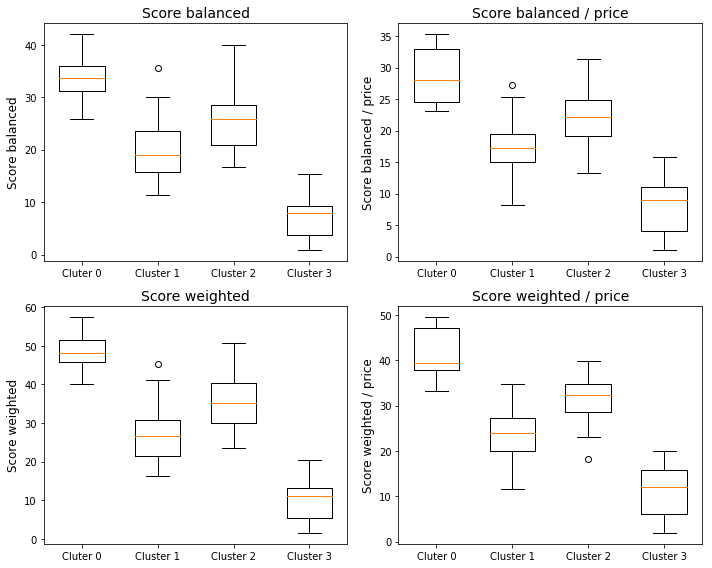

In [257]:
fig, axs = plt.subplots(2,2,figsize=(10,8))

X = [1,2,3,4]
labels = ['Cluter 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
W=.6

# Score balanced
axs[0,0].boxplot([clus0['Score balanced'], clus1['Score balanced'], 
                  clus2['Score balanced'], clus3['Score balanced']], 
                 showfliers=True, widths=W)

axs[0,0].set_xticks(ticks=X)
axs[0,0].set_xticklabels(labels, fontsize=10)
axs[0,0].set_ylabel('Score balanced', fontsize=12)
axs[0,0].set_title('Score balanced', fontsize=14)

# Score weighted
axs[1,0].boxplot([clus0['Score weighted'], clus1['Score weighted'],
                  clus2['Score weighted'], clus3['Score weighted']], 
                 showfliers=True, widths=W)

axs[1,0].set_xticks(ticks=X)
axs[1,0].set_xticklabels(labels, fontsize=10)
axs[1,0].set_ylabel('Score weighted', fontsize=12)
axs[1,0].set_title('Score weighted', fontsize=14)

# Score balanced / price
axs[0,1].boxplot([clus0['Score balanced / price'], clus1['Score balanced / price'], 
                  clus2['Score balanced / price'], clus3['Score balanced / price']], 
                 showfliers=True, widths=W)

axs[0,1].set_xticks(ticks=X)
axs[0,1].set_xticklabels(labels, fontsize=10)
axs[0,1].set_ylabel('Score balanced / price', fontsize=12)
axs[0,1].set_title('Score balanced / price', fontsize=14)

# Score weighted / price
axs[1,1].boxplot([clus0['Score weighted / price'], clus1['Score weighted / price'],
                  clus2['Score weighted / price'], clus3['Score weighted / price']], 
                 showfliers=True, widths=W)

axs[1,1].set_xticks(ticks=X)
axs[1,1].set_xticklabels(labels, fontsize=10)
axs[1,1].set_ylabel('Score weighted / price', fontsize=12)
axs[1,1].set_title('Score weighted / price', fontsize=14)

plt.tight_layout()
plt.savefig('clusters analysis.png')
plt.show()

###### Best neighborhoods map

In [272]:
import matplotlib.cm as cm
import matplotlib.colors as colors

scale = list(i for i in np.linspace(start=df_paris['Price (EUR/m2)'].min()-.1,
                                    stop=df_paris['Price (EUR/m2)'].max()+.1,
                                    num=5))

# create map
map_clusters = folium.Map(location=[paris_latitude, paris_longitude],
                          zoom_start=12, tiles='cartodbpositron')
map_clusters.choropleth(
    geo_data=neigh_json,
    data=df_paris,
    columns=['Neighborhood', 'Price (EUR/m2)'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name='Property Prices (EUR/m2)',
    threshold_scale=scale
)


# add markers to the map
markers_colors = []
for lat, lon, price, name in zip(df_paris.Latitude, df_paris.Longitude, df_paris['Price (EUR/m2)'],
                                 df_paris.Neighborhood):
    label = folium.Popup('%s: %d EUR/m2' %(name, price), parse_html=True)
    if name not in labels_gym.to_list():
        col = 'red'
    elif name in top20.to_list():
        col = 'yellow'
    else:
        col = 'blue'
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        label=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7).add_to(map_clusters)

map_clusters.save('best neighborhoods.html')
map_clusters
